In [1]:
# make sure you've got the following packages installed
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image

In [2]:
fname = 'lena.png'
greyscale_image = Image.open(fname).convert("L")
arr = np.asarray(greyscale_image)

In [3]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

(17, 16)
(17, 17)


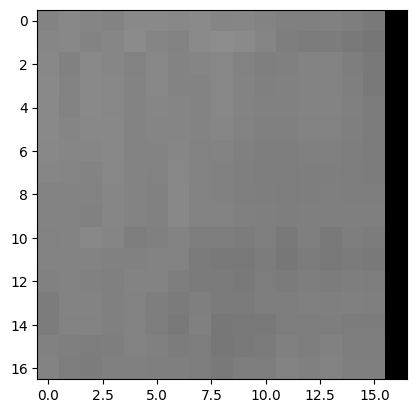

In [4]:
patch_size = 16
patch = arr[0:patch_size+1, 0:patch_size]
print(patch.shape)
patch = np.pad(patch, ((0, 0), (0, 1)), mode='constant')
print(patch.shape)
plt.imshow(patch, cmap='gray', vmin=0, vmax=255)
plt.show()


In [5]:
# parameters
N = arr.shape[0]
patch_size = 16 # either 8 or 16
M = N // patch_size
sample_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
sparsity_threshold = 1e-3
errors = np.zeros((M, M, len(sample_percentages)))
sparsities = np.zeros((M, M, len(sample_percentages)))
reconstructed_image = np.zeros((N+1, N+1, len(sample_percentages)))
print(reconstructed_image.shape)

(513, 513, 5)


In [6]:
for k in range(len(sample_percentages)):
    for i in range(0, arr.shape[0], patch_size):
        for j in range(0, arr.shape[1], patch_size):
            if (i + patch_size >= arr.shape[0]) and (j + patch_size < arr.shape[1]):
                # last row
                patch = arr[i:i+patch_size, j:j+patch_size + 1]
                patch = np.pad(patch, ((0, 1), (0, 0)), mode='constant')
            
            elif (i + patch_size < arr.shape[0]) and (j + patch_size >= arr.shape[1]):
                # last column
                patch = arr[i:i+patch_size + 1, j:j+patch_size]
                patch = np.pad(patch, ((0, 0), (0, 1)), mode='constant')
                
            elif (i + patch_size >= arr.shape[0]) and (j + patch_size >= arr.shape[1]):
                # last row and column
                patch = arr[i:i+patch_size, j:j+patch_size]
                patch = np.pad(patch, ((0, 1), (0, 1)), mode='constant')

            else:
                patch = arr[i:i+patch_size + 1, j:j+patch_size + 1]

            nx, ny = patch.shape

            # subsampling
            m = round(nx * ny * sample_percentages[k])
            ri = np.random.choice(nx * ny, m, replace=False)

            A = np.kron(
                spfft.idct(np.identity(patch.shape[0]), norm='ortho', axis=0),
                spfft.idct(np.identity(patch.shape[1]), norm='ortho', axis=0)
            )
            A = A[ri, :] # subsampled

            b = patch.T.flatten()[ri] # subsampled

            vx = cvx.Variable(nx * ny)
            objective = cvx.Minimize(cvx.norm(vx, 1))
            constraints = [A@vx == b]
            prob = cvx.Problem(objective, constraints)
            result = prob.solve(verbose=False)
            Xat2 = np.array(vx.value).squeeze()

            Xat = Xat2.reshape(nx, ny).T # stack columns
            Xa = idct2(Xat)
            
            # Store the reconstructed patch in the result image
            err = ((patch - Xa)**2).mean()
            errors[i//patch_size, j//patch_size, k] = err

            sparsity = np.count_nonzero(Xat > sparsity_threshold)
            sparsities[i//patch_size, j//patch_size, k] = sparsity

            reconstructed_image[i:i+patch_size+1, j:j+patch_size+1, k] += Xa

In [7]:
np.save(os.path.join(os.getcwd(), 'results', 'reconstructed_image_2DCT_overlap.npy'), reconstructed_image)
np.save(os.path.join(os.getcwd(), 'results', 'errors_2DCT_overlap.npy'), errors)
np.save(os.path.join(os.getcwd(), 'results', 'sparsities_2DCT_overlap.npy'), sparsities)

In [8]:
reconstructed_image_columns = np.load(os.path.join(os.getcwd(), 'results', 'reconstructed_image_2DCT_overlap.npy'))
errors_columns = np.load(os.path.join(os.getcwd(), 'results', 'errors_2DCT_overlap.npy'))
sparsities_columns = np.load(os.path.join(os.getcwd(), 'results', 'sparsities_2DCT_overlap.npy'))

In [9]:
# remove the padding
reconstructed_image_columns = reconstructed_image[:-1, :-1, :]
# reconstructed_image_columns = reconstructed_image_columns[:-1, :-1, :]

In [10]:
patch_size = 16 
sample_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]

for k in range(len(sample_percentages)):
    for i in range(patch_size, arr.shape[0], patch_size):
        reconstructed_image_columns[i, :, k] /= 2

for k in range(len(sample_percentages)):
    for j in range(patch_size, arr.shape[1], patch_size):
        reconstructed_image_columns[:, j, k] /= 2

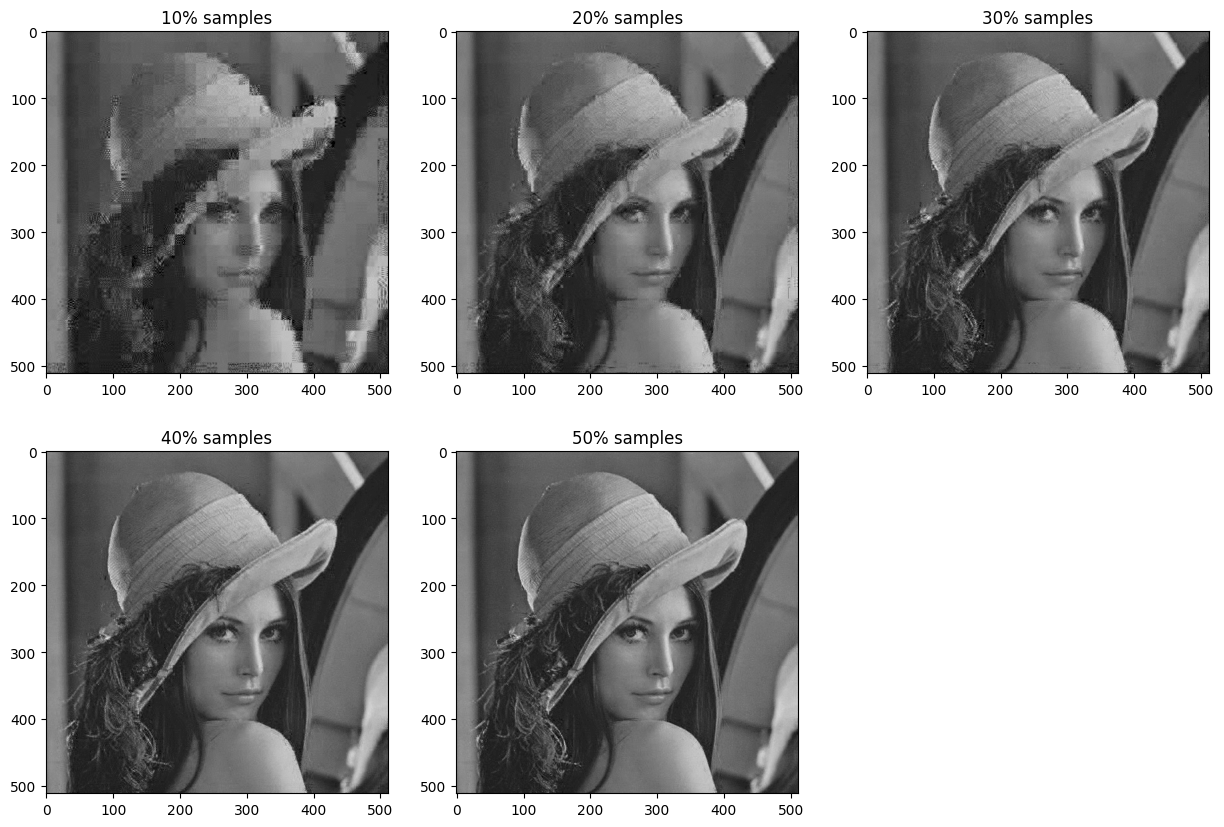

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(reconstructed_image_columns[:, :, 0], cmap='gray', vmin=0, vmax=255)
plt.title(f'10% samples')
plt.subplot(2, 3, 2)
plt.imshow(reconstructed_image_columns[:, :, 1], cmap='gray', vmin=0, vmax=255)
plt.title(f'20% samples')
plt.subplot(2, 3, 3)
plt.imshow(reconstructed_image_columns[:, :, 2], cmap='gray', vmin=0, vmax=255)
plt.title(f'30% samples')
plt.subplot(2, 3, 4)
plt.imshow(reconstructed_image_columns[:, :, 3], cmap='gray', vmin=0, vmax=255)
plt.title(f'40% samples')
plt.subplot(2, 3, 5)
plt.imshow(reconstructed_image_columns[:, :, 4], cmap='gray', vmin=0, vmax=255)
plt.title(f'50% samples')
plt.show()

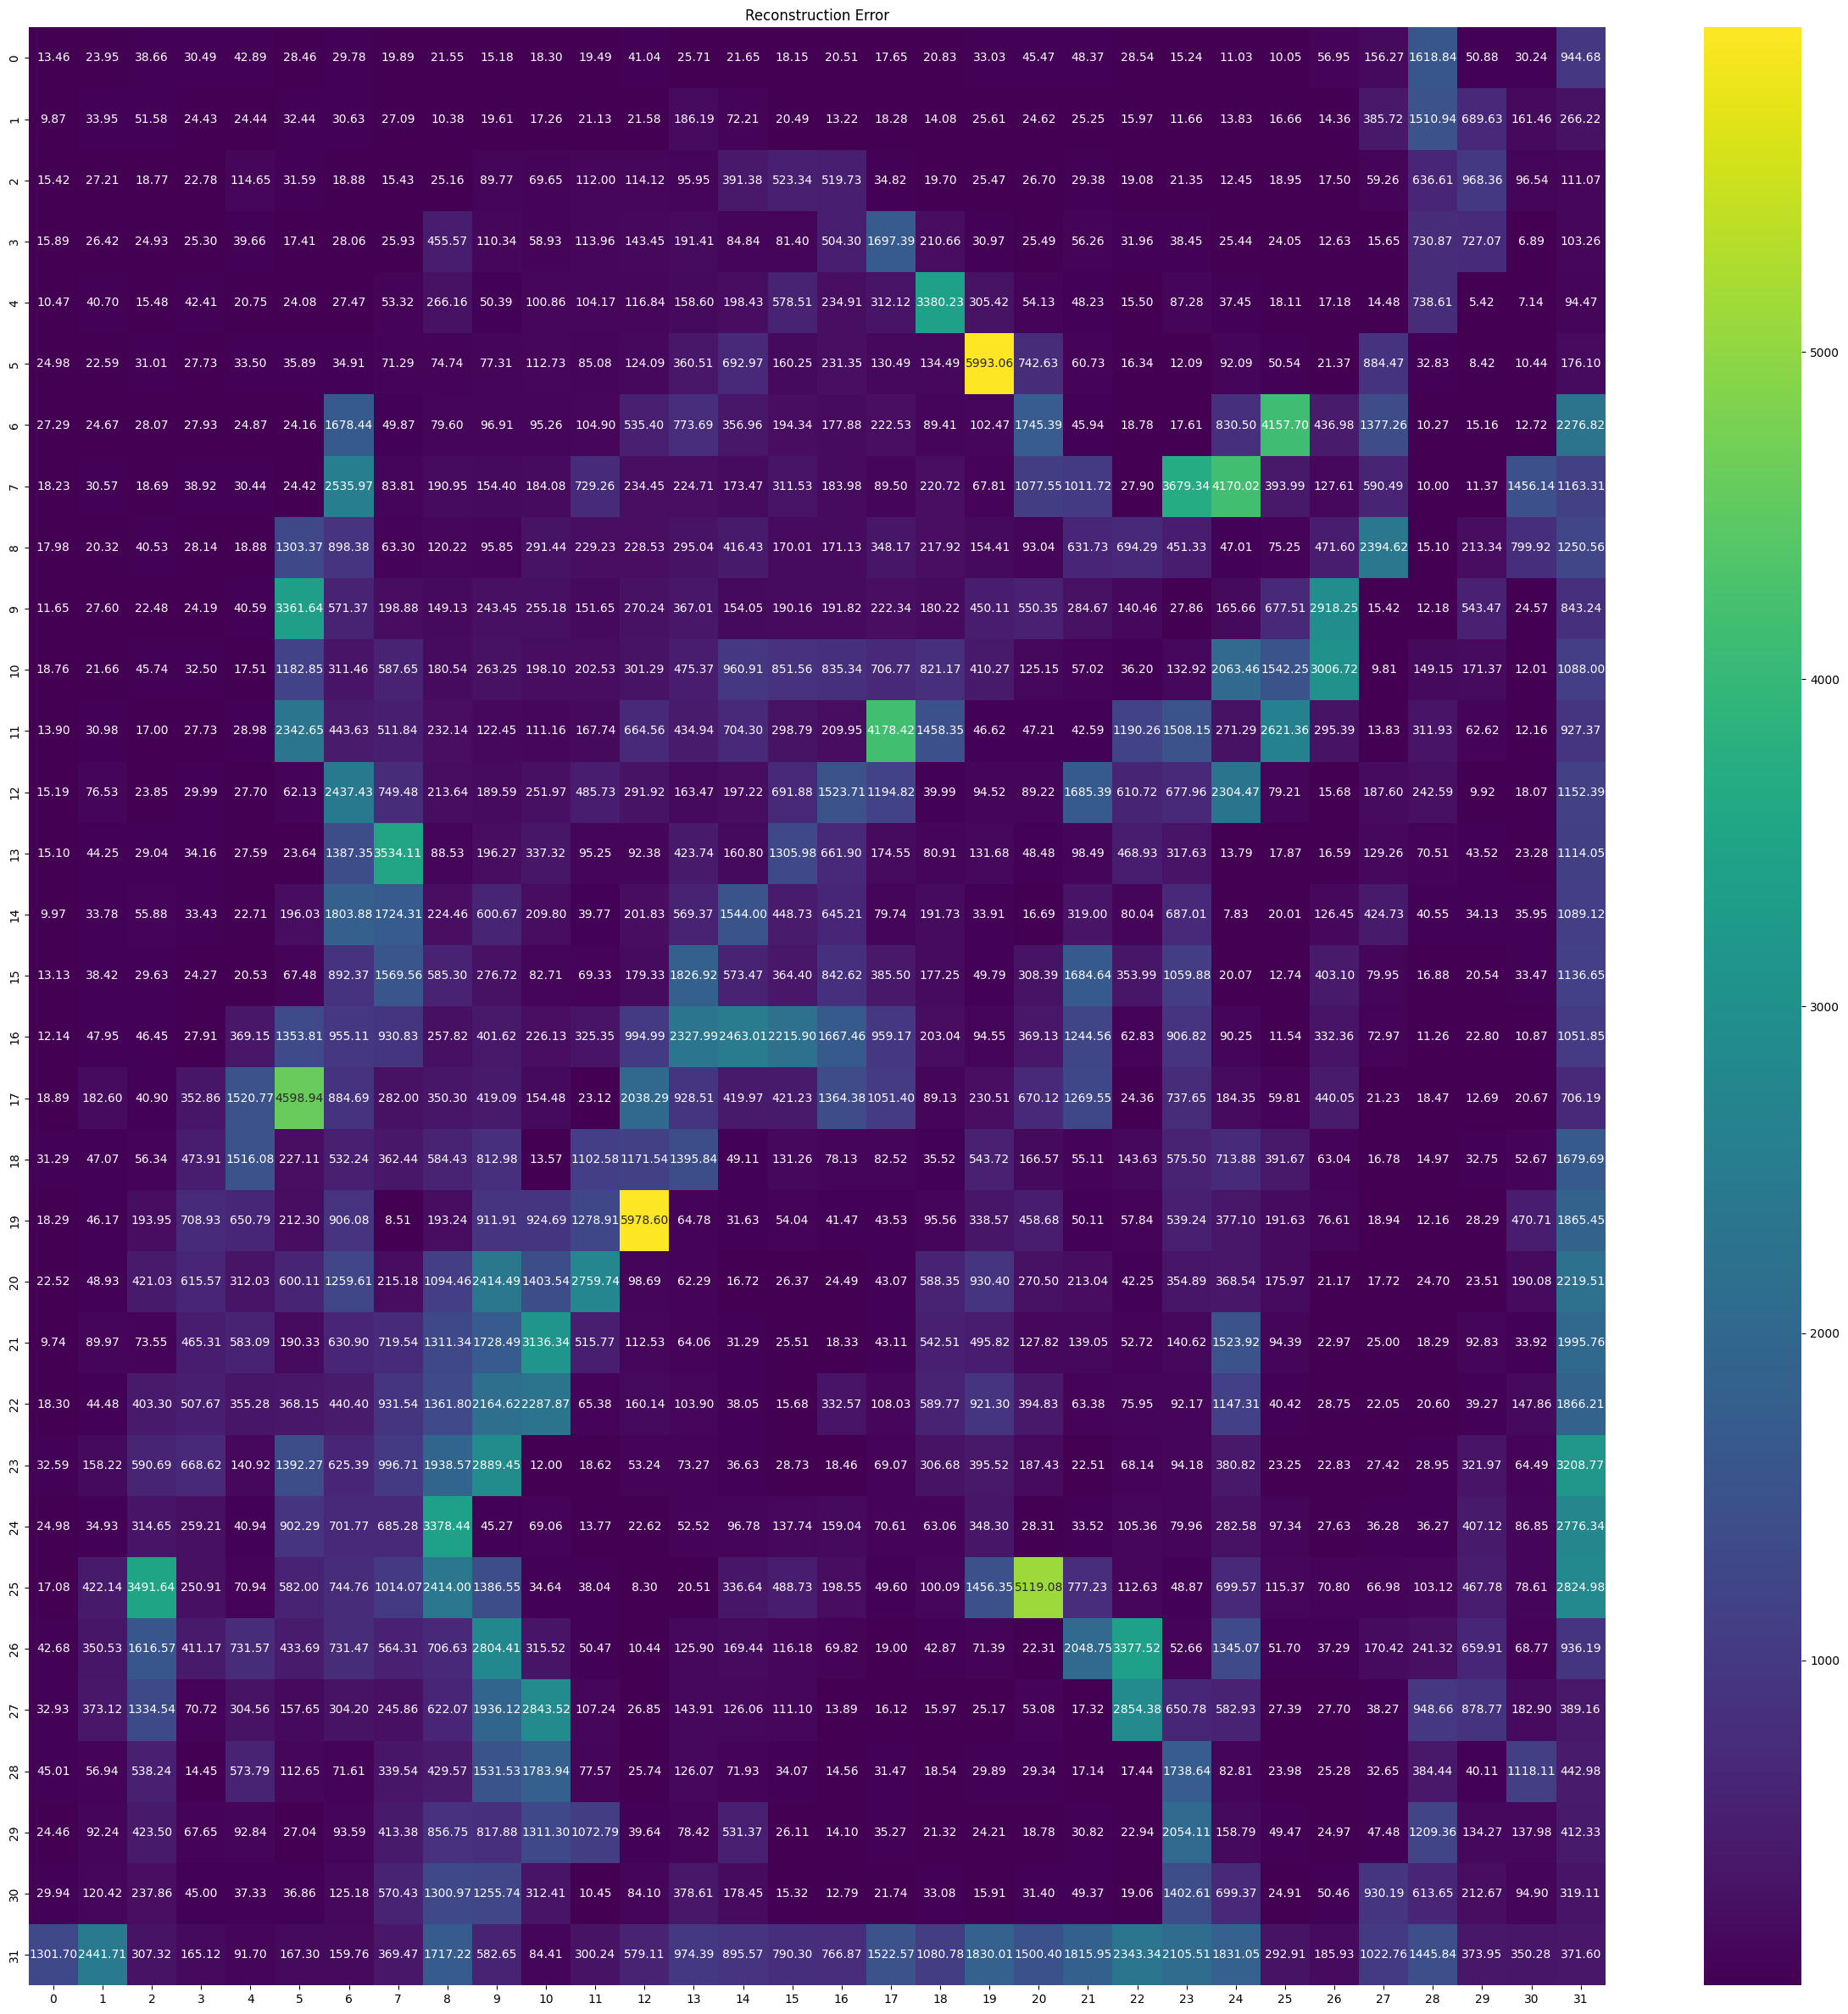

In [12]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(errors[:, :, 0], annot=True, fmt=".2f", cmap='viridis')
plt.show()

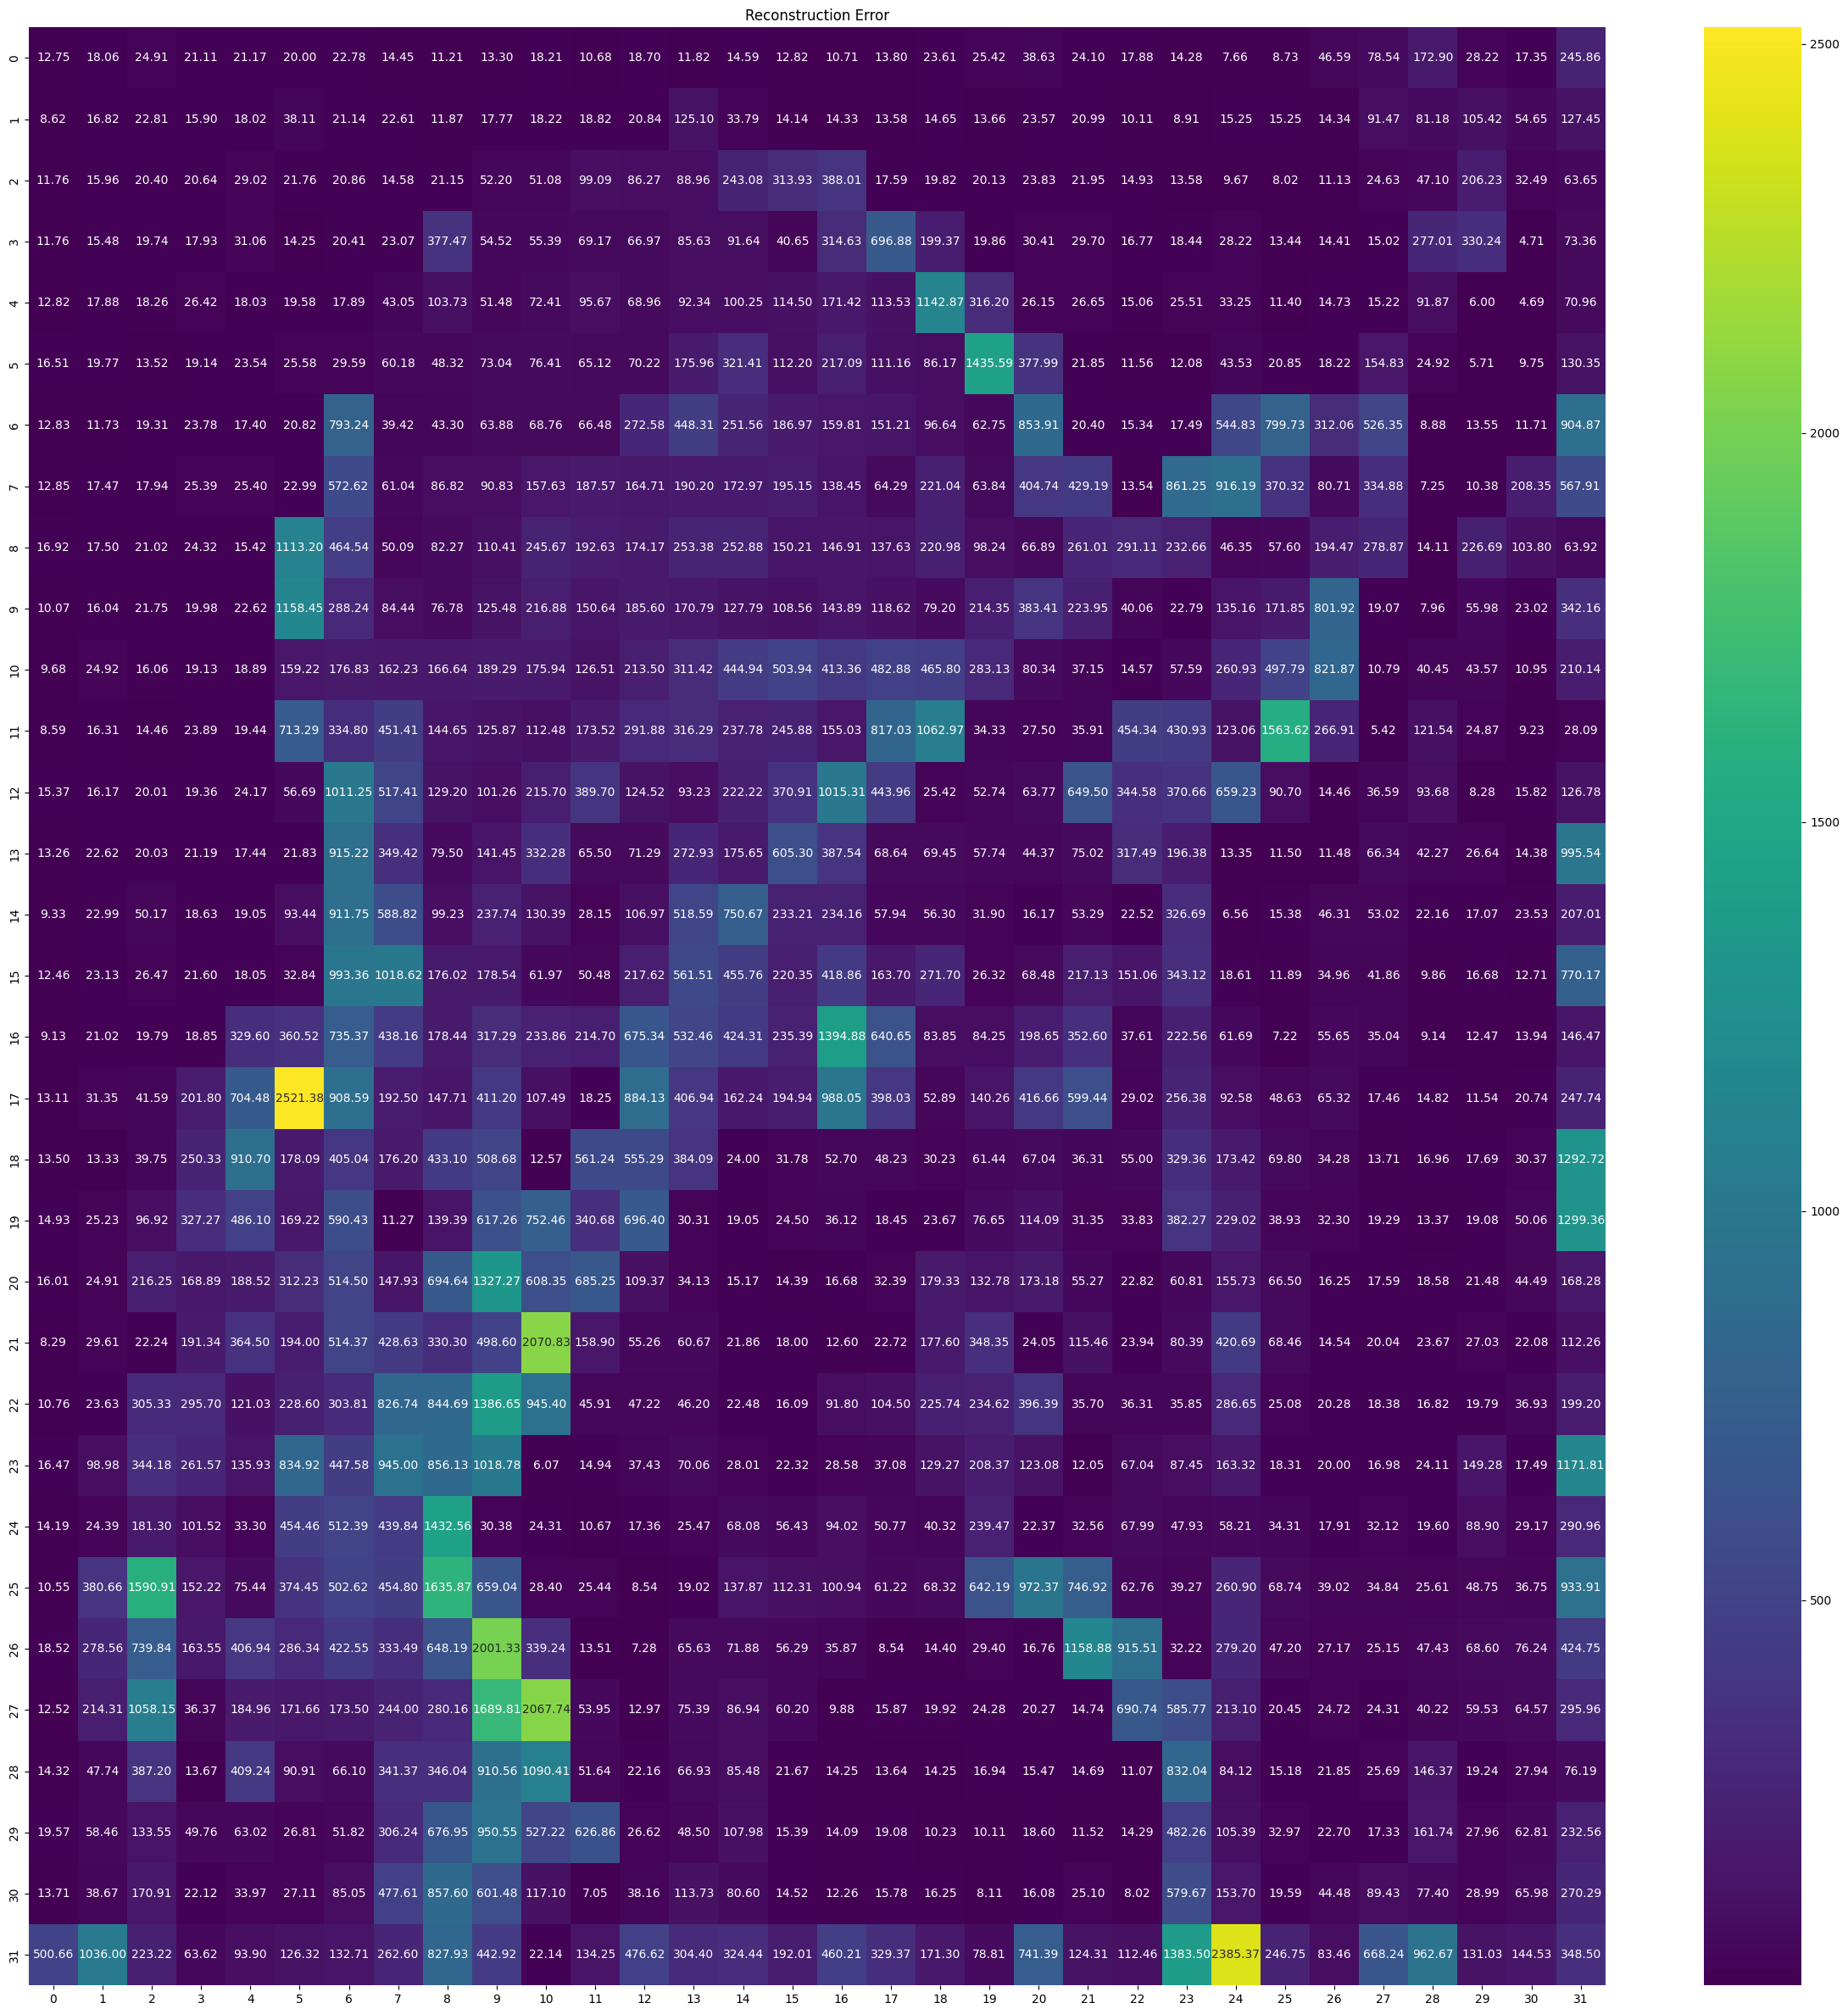

In [13]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(errors[:, :, 1], annot=True, fmt=".2f", cmap='viridis')
plt.show()

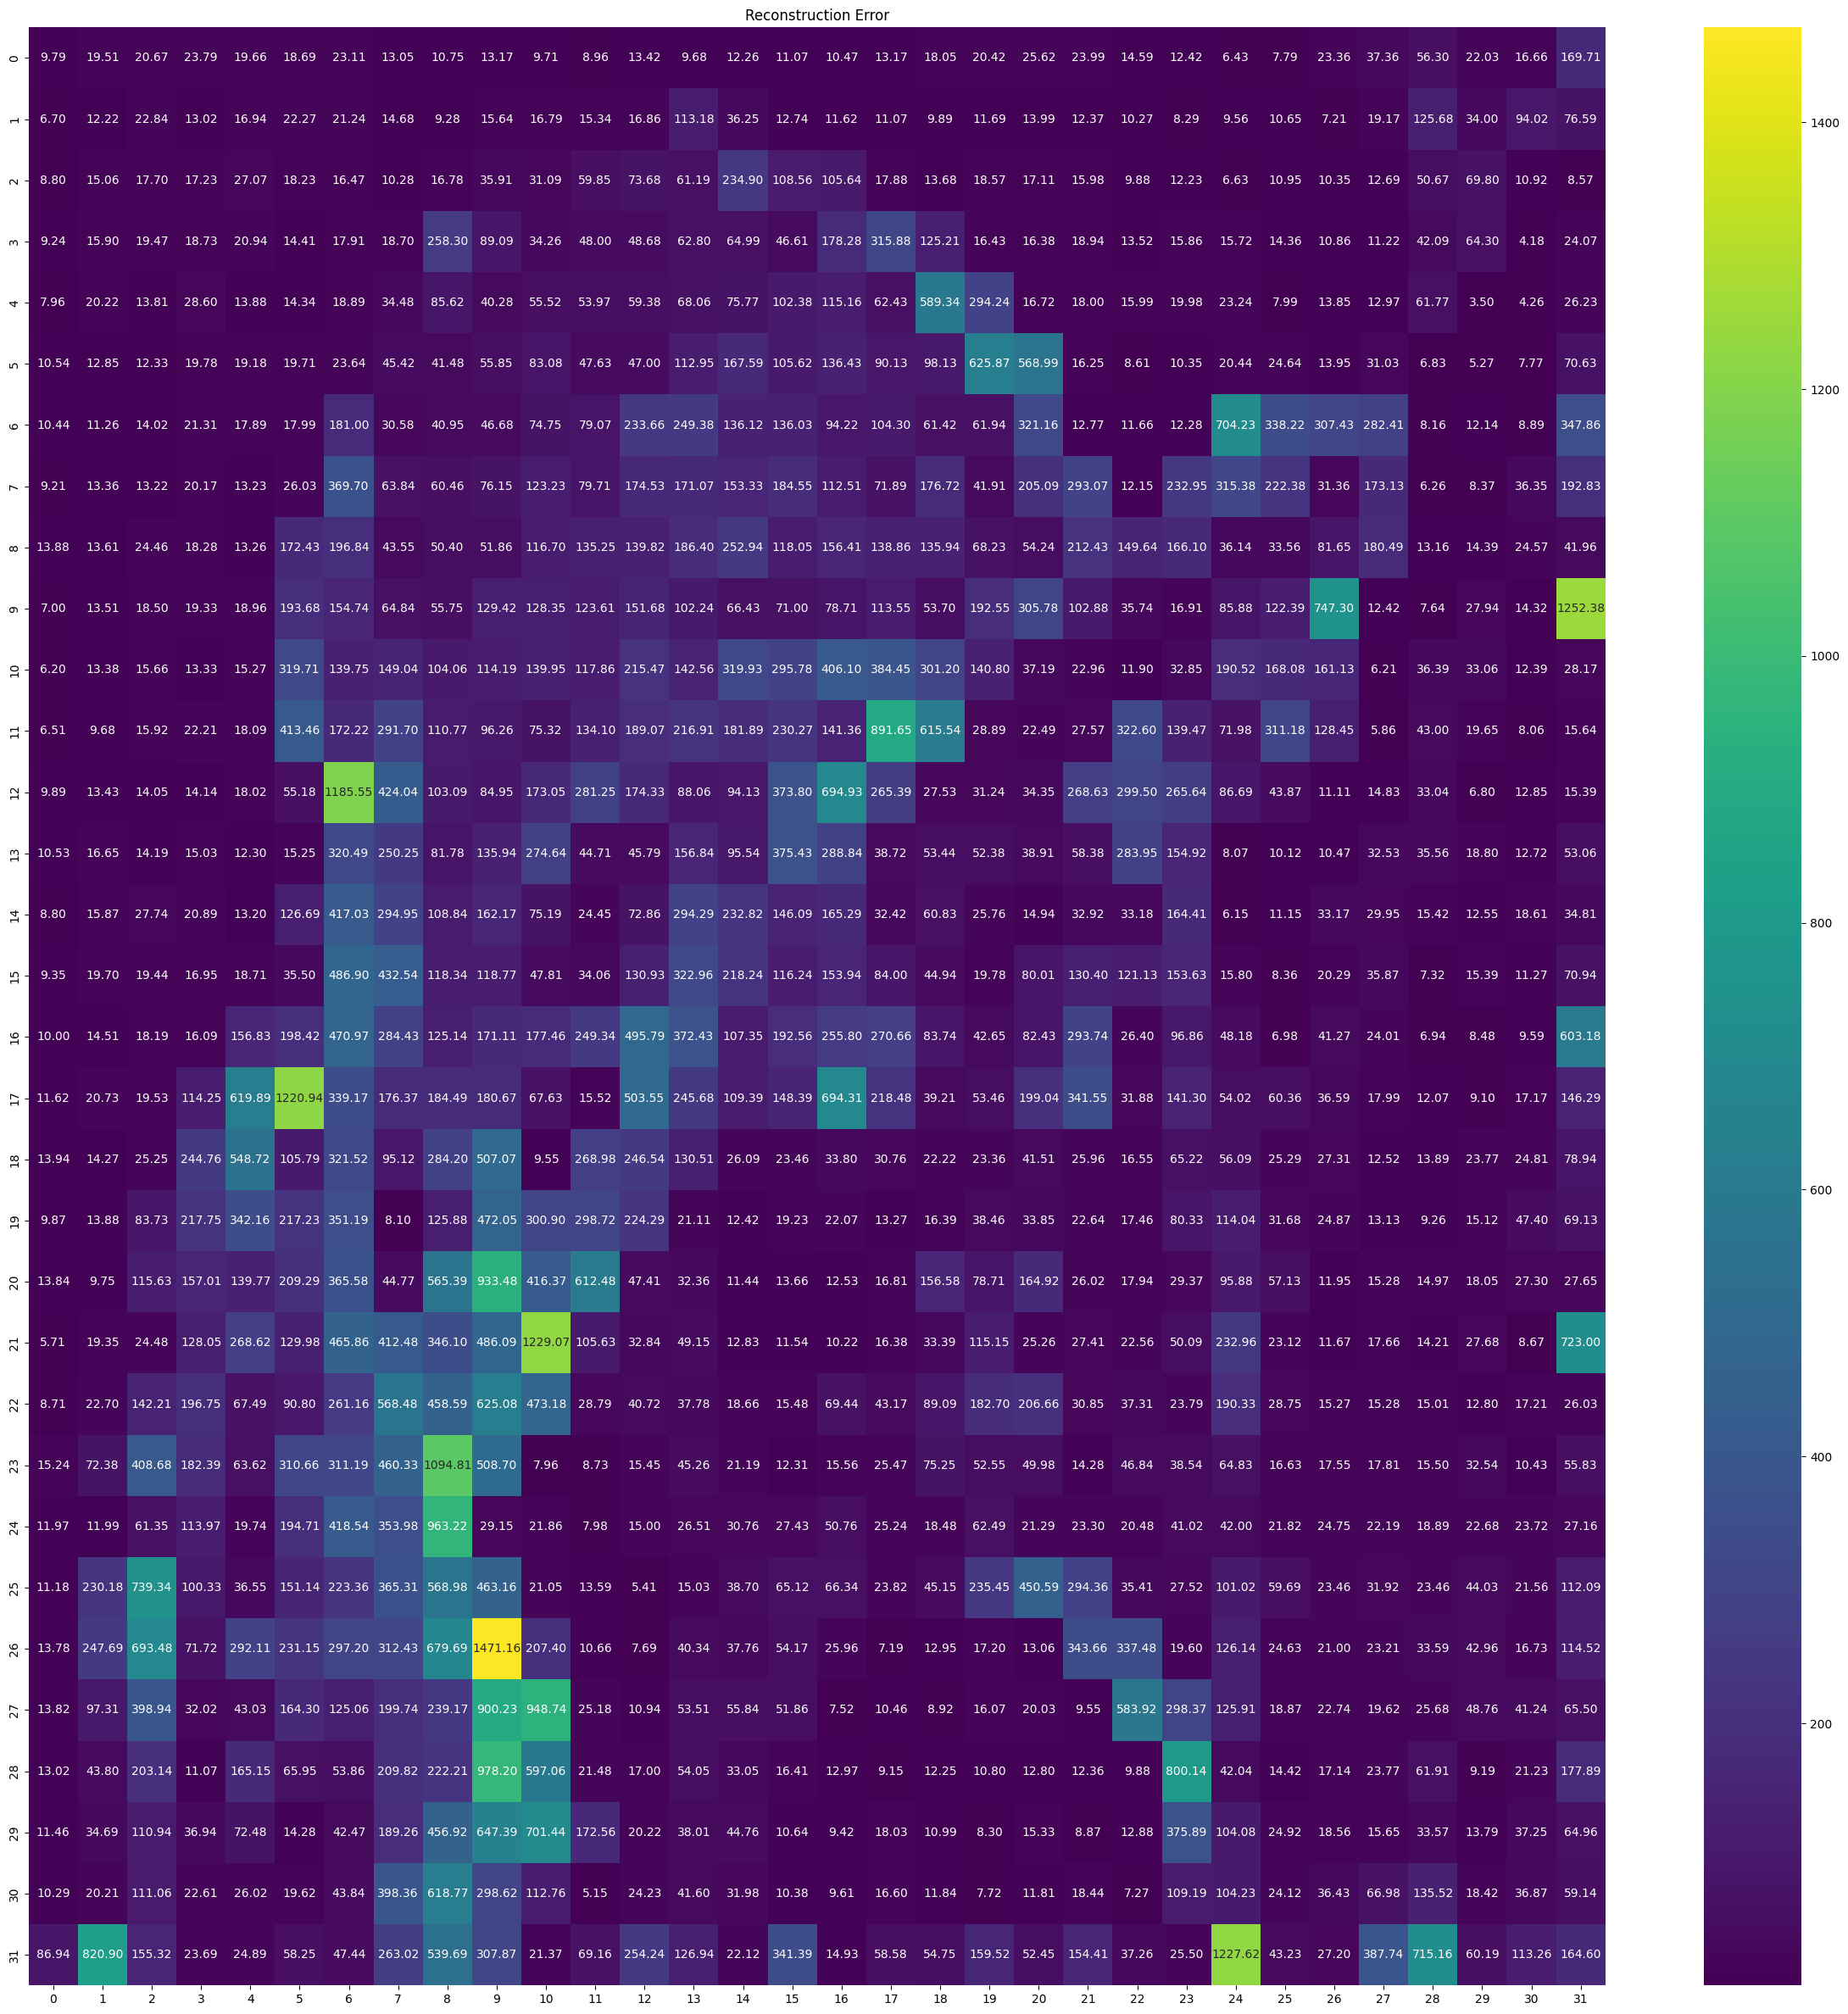

In [14]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(errors[:, :, 2], annot=True, fmt=".2f", cmap='viridis')
plt.show()

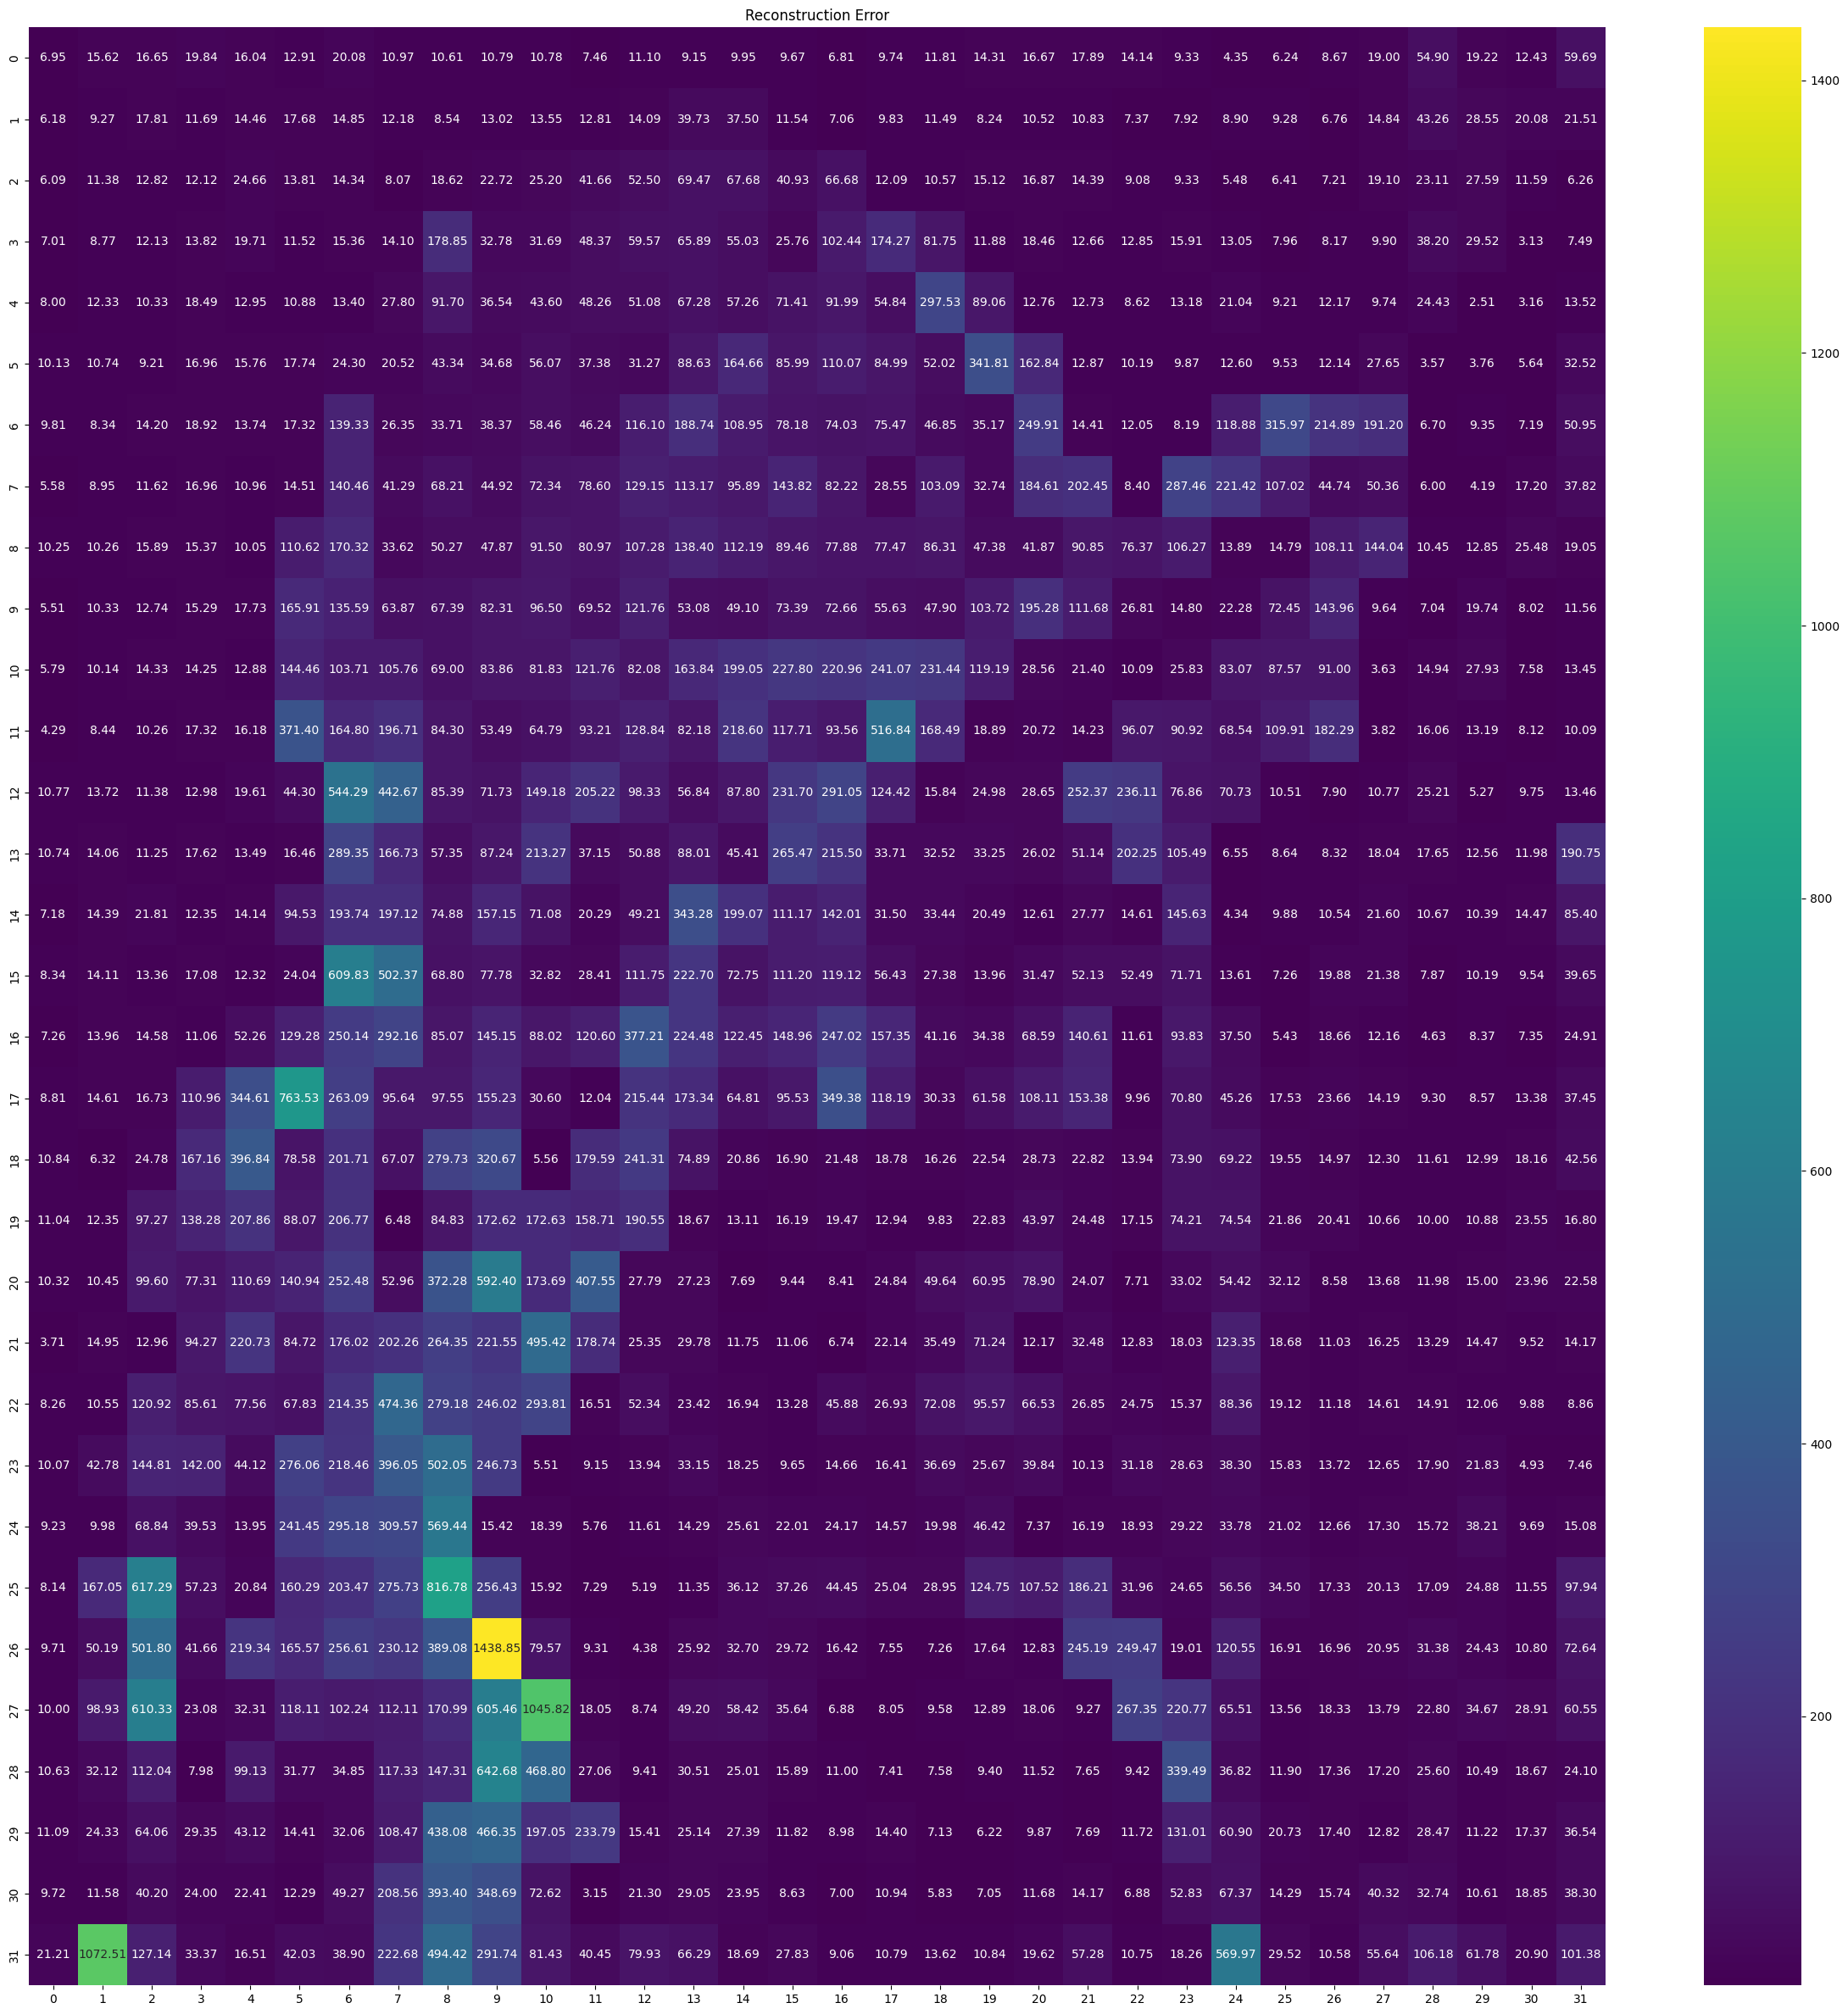

In [15]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(errors[:, :, 3], annot=True, fmt=".2f", cmap='viridis')
plt.show()

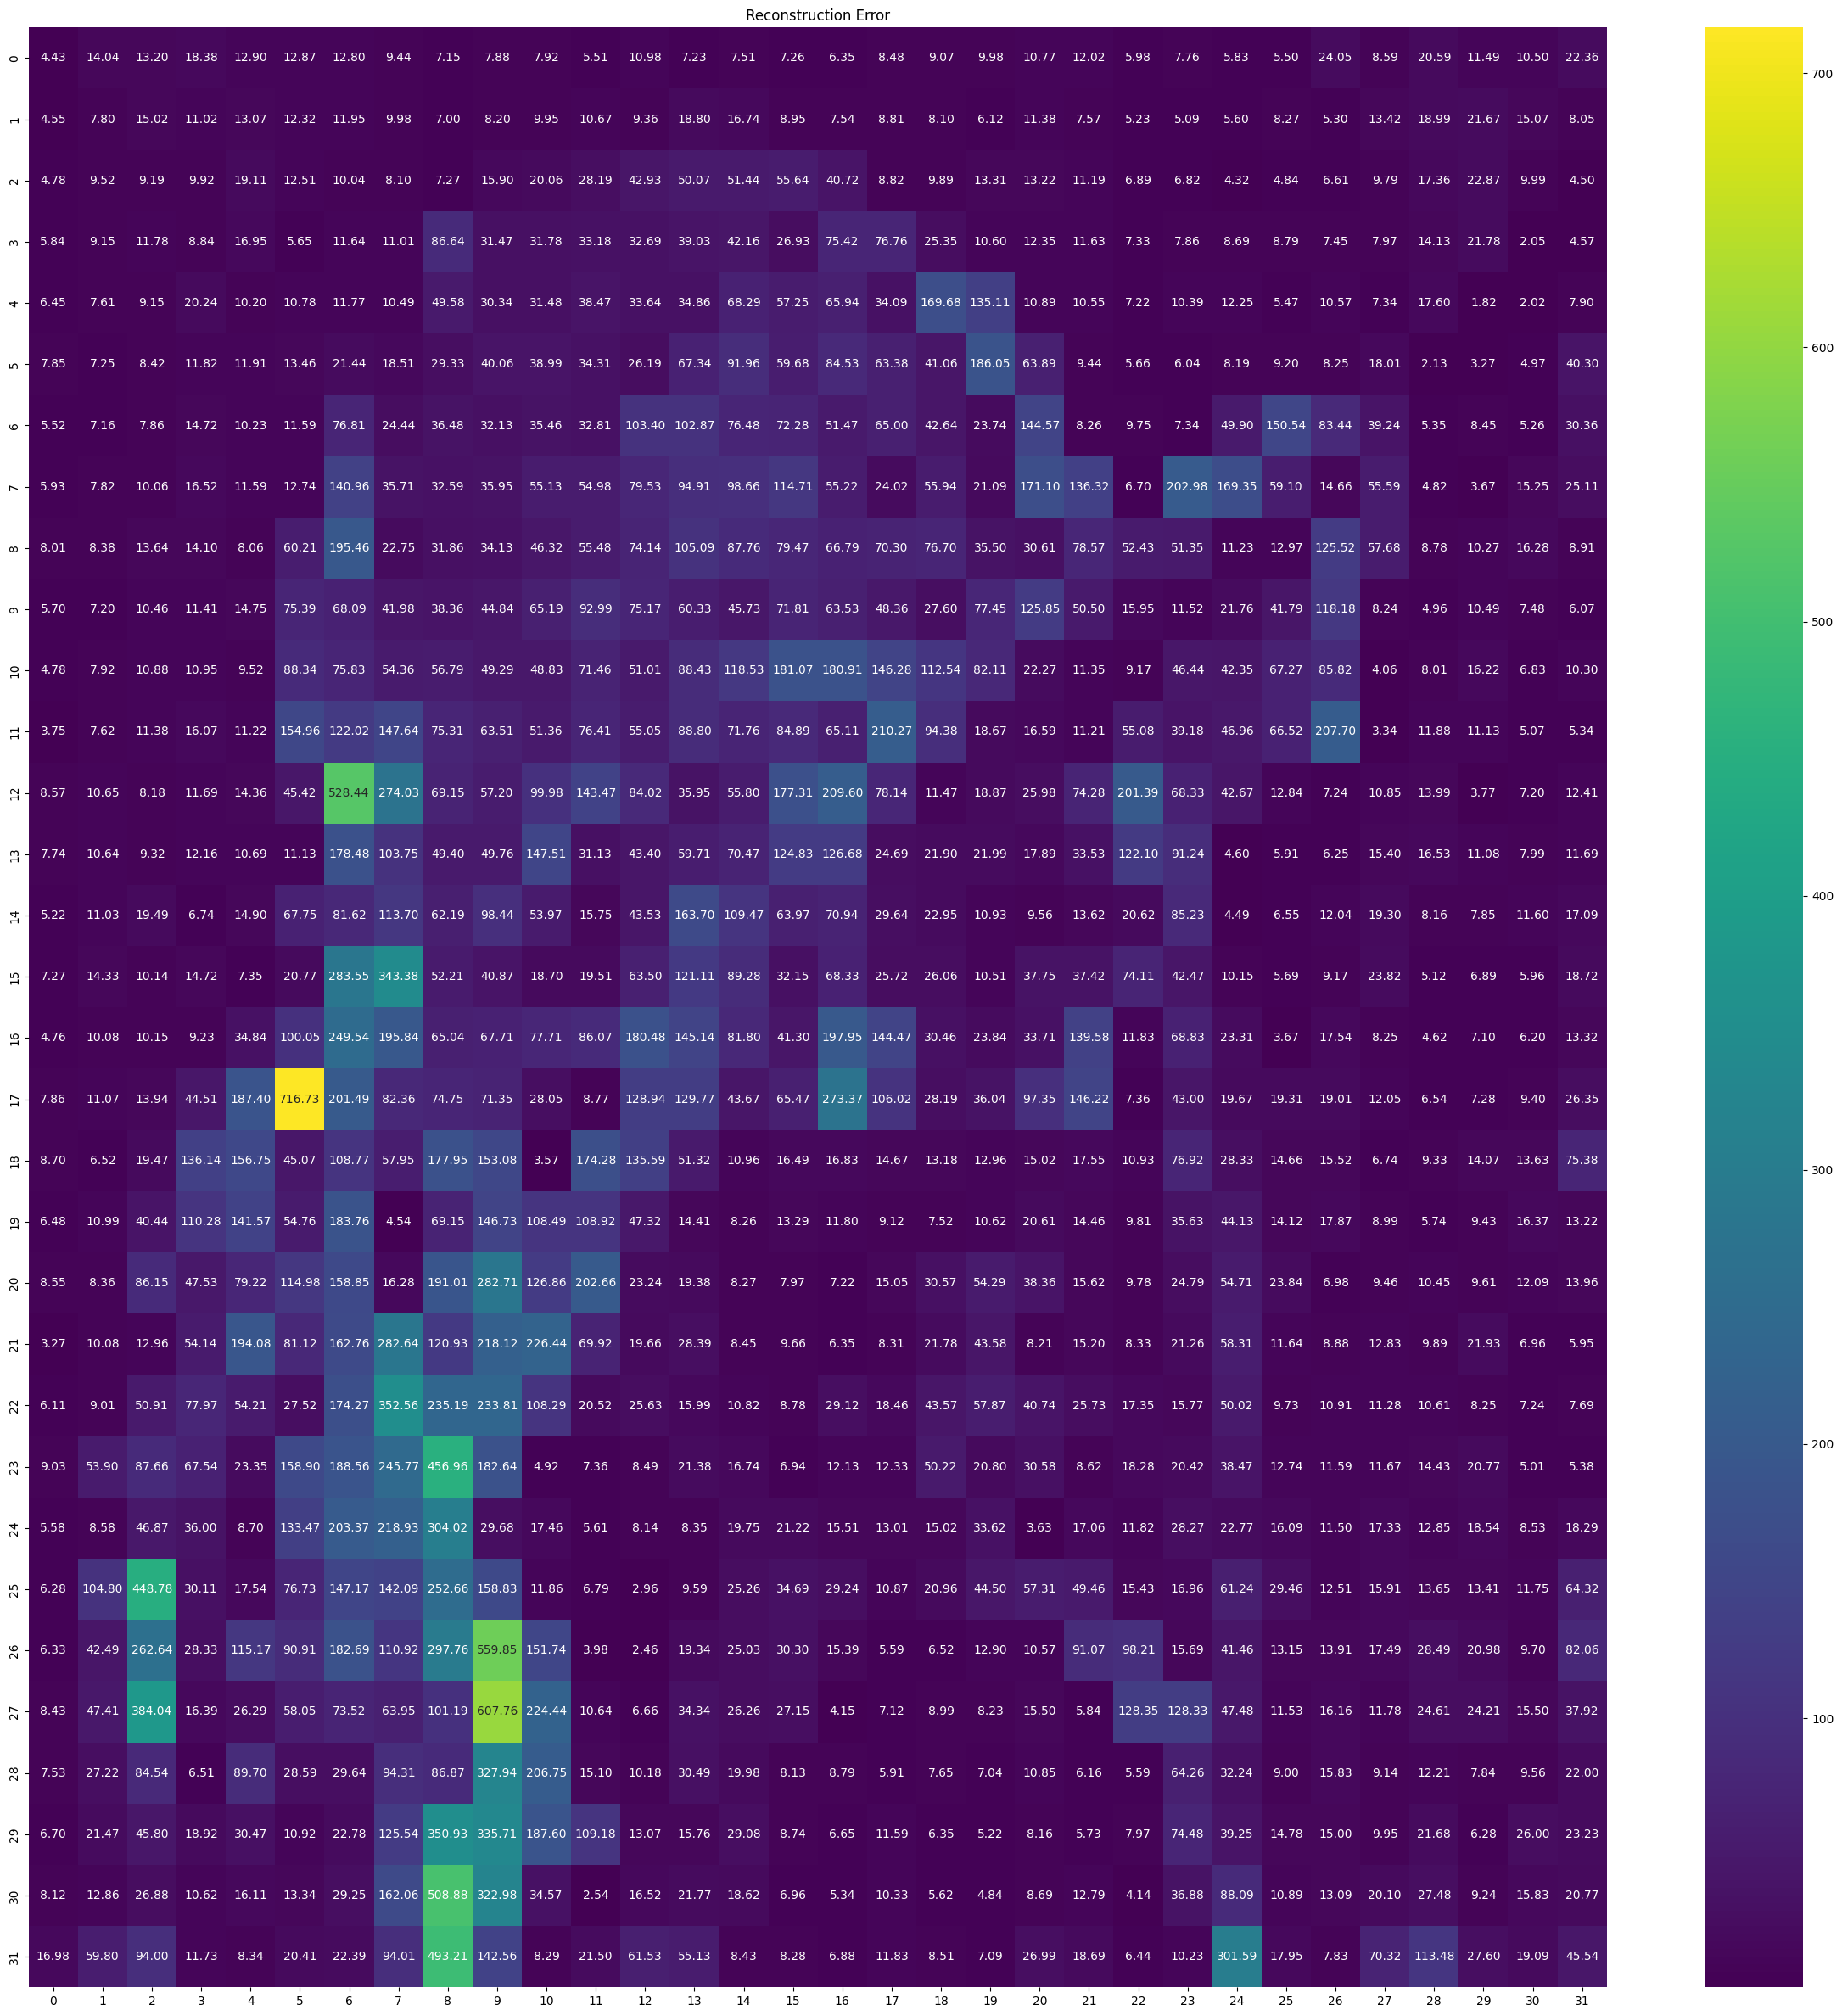

In [16]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(errors[:, :, 4], annot=True, fmt=".2f", cmap='viridis')
plt.show()

In [17]:
print(np.mean(sparsities[:, :, 0]))
print(np.mean(sparsities[:, :, 1]))
print(np.mean(sparsities[:, :, 2]))
print(np.mean(sparsities[:, :, 3]))
print(np.mean(sparsities[:, :, 4]))

14.9013671875
29.4013671875
43.9189453125
58.6064453125
72.46484375


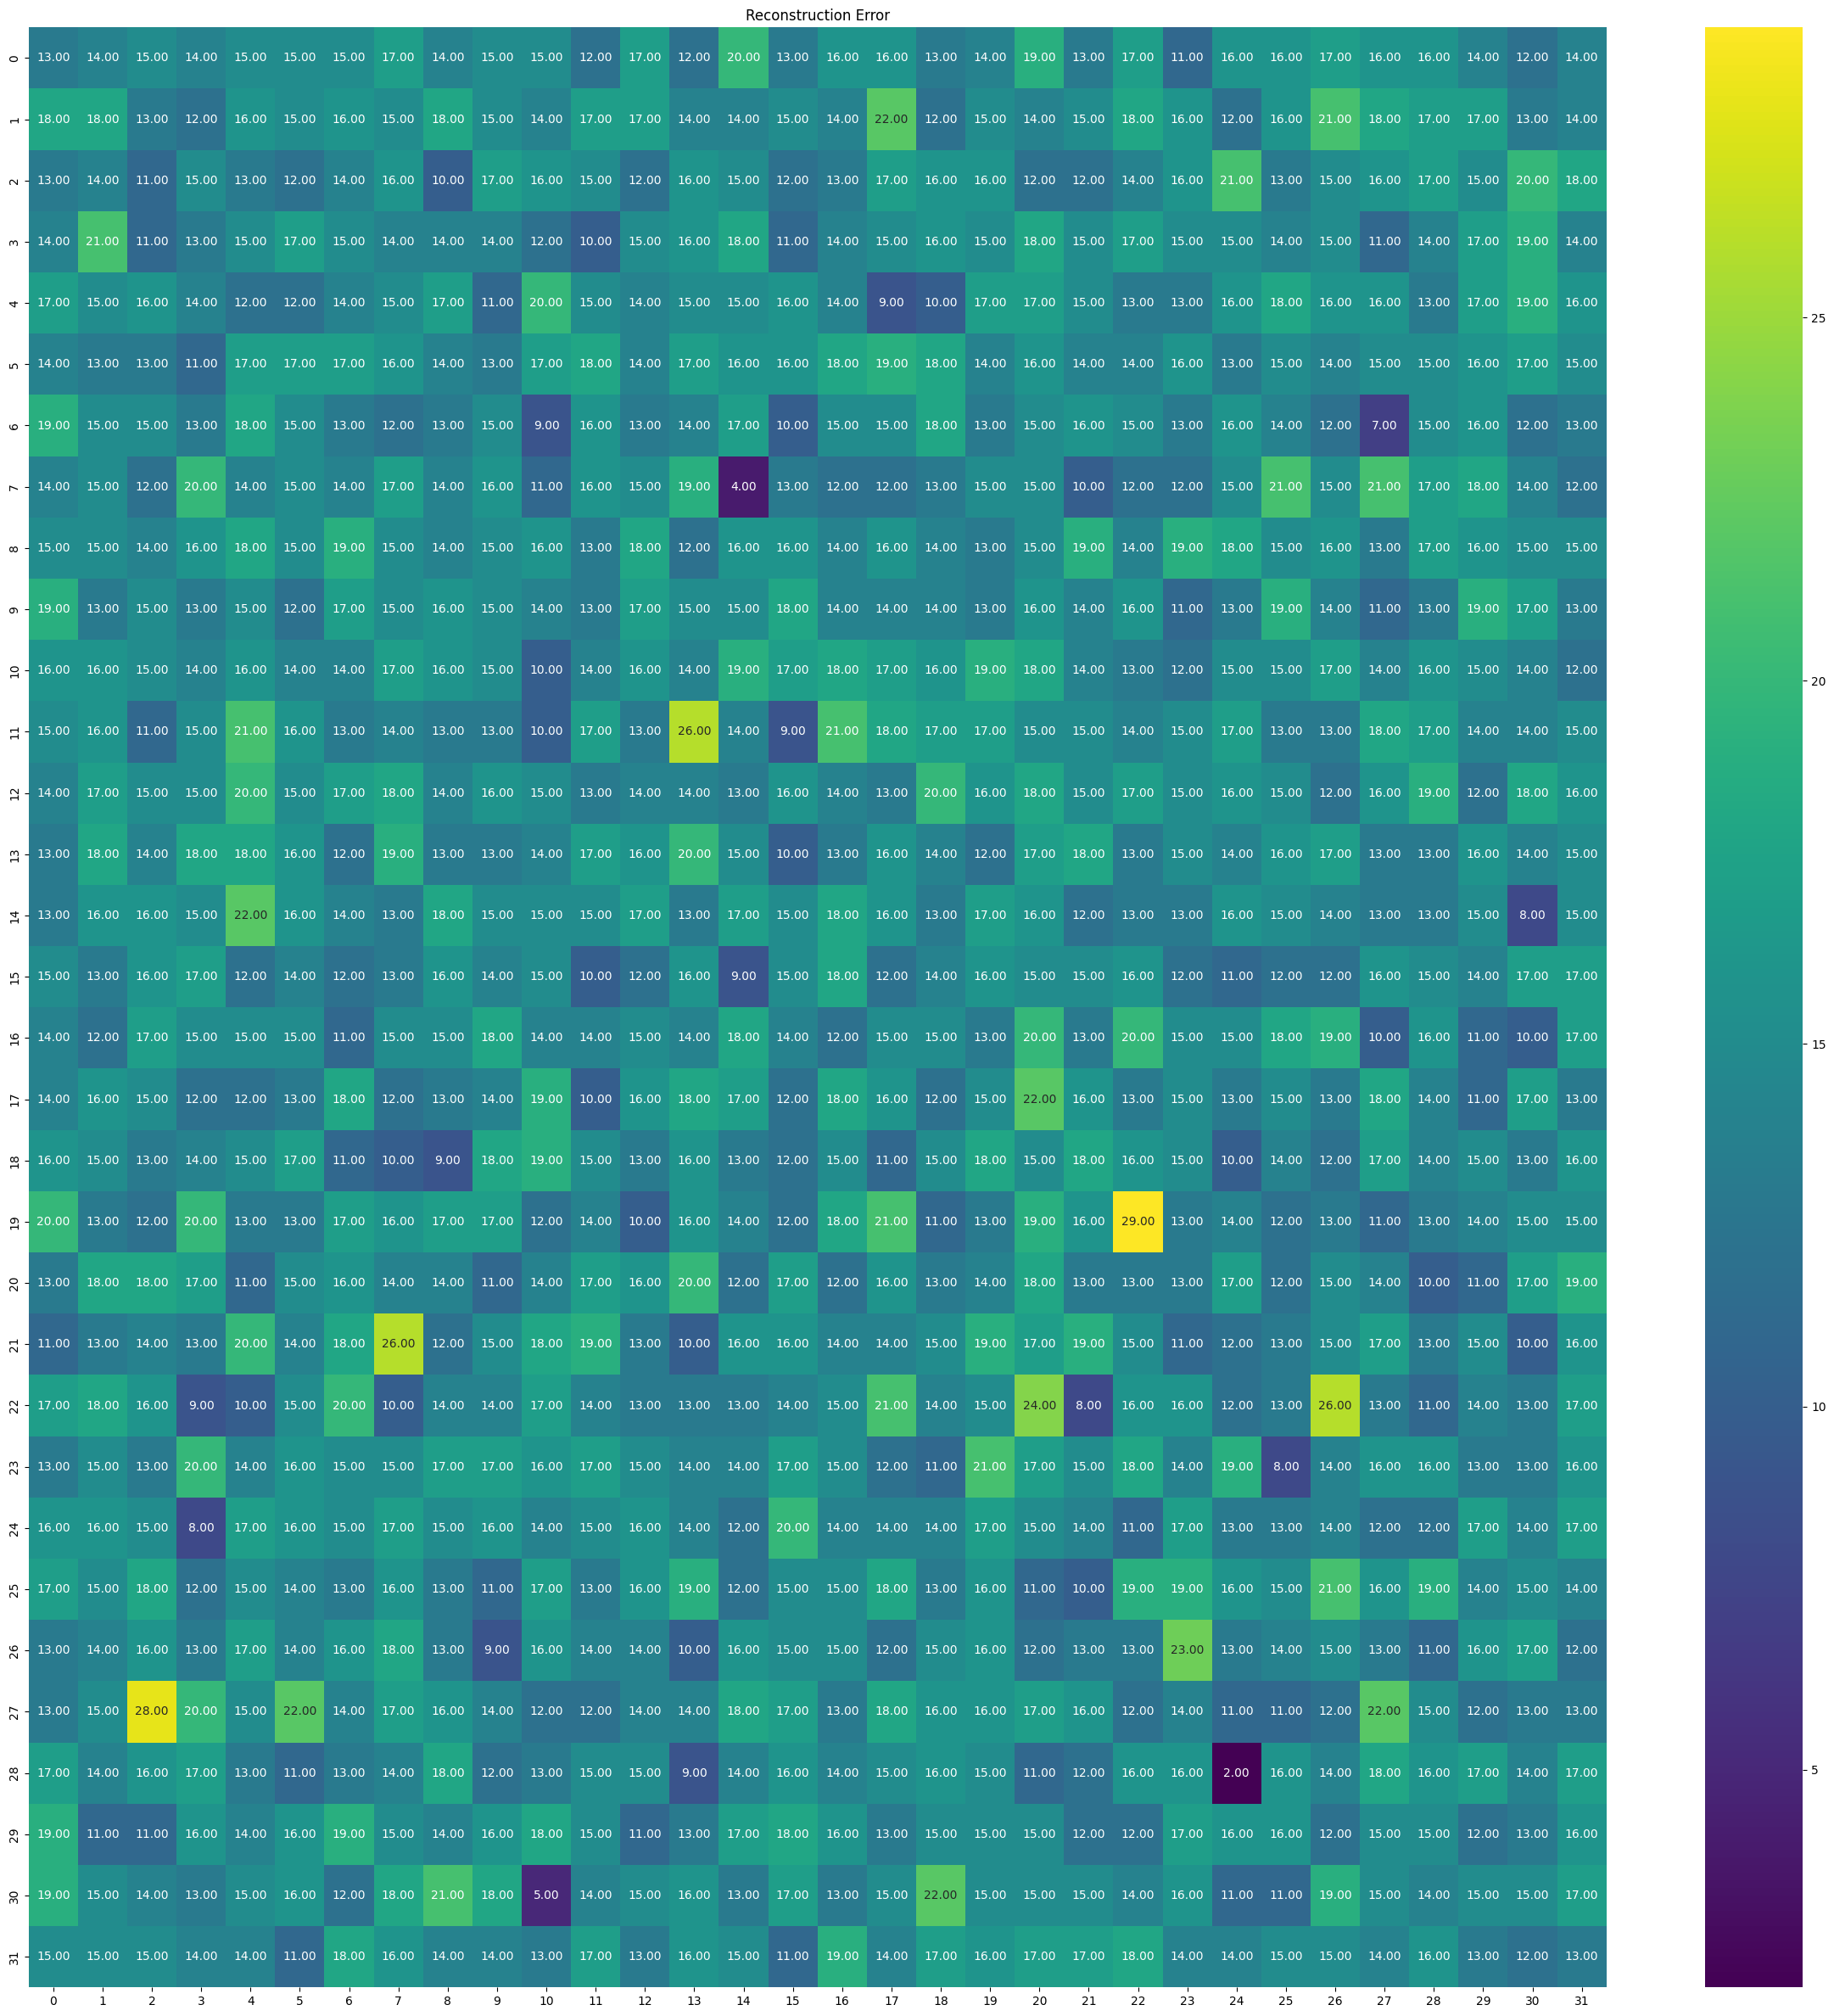

In [18]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(sparsities[:, :, 0], annot=True, fmt=".2f", cmap='viridis')
plt.show()

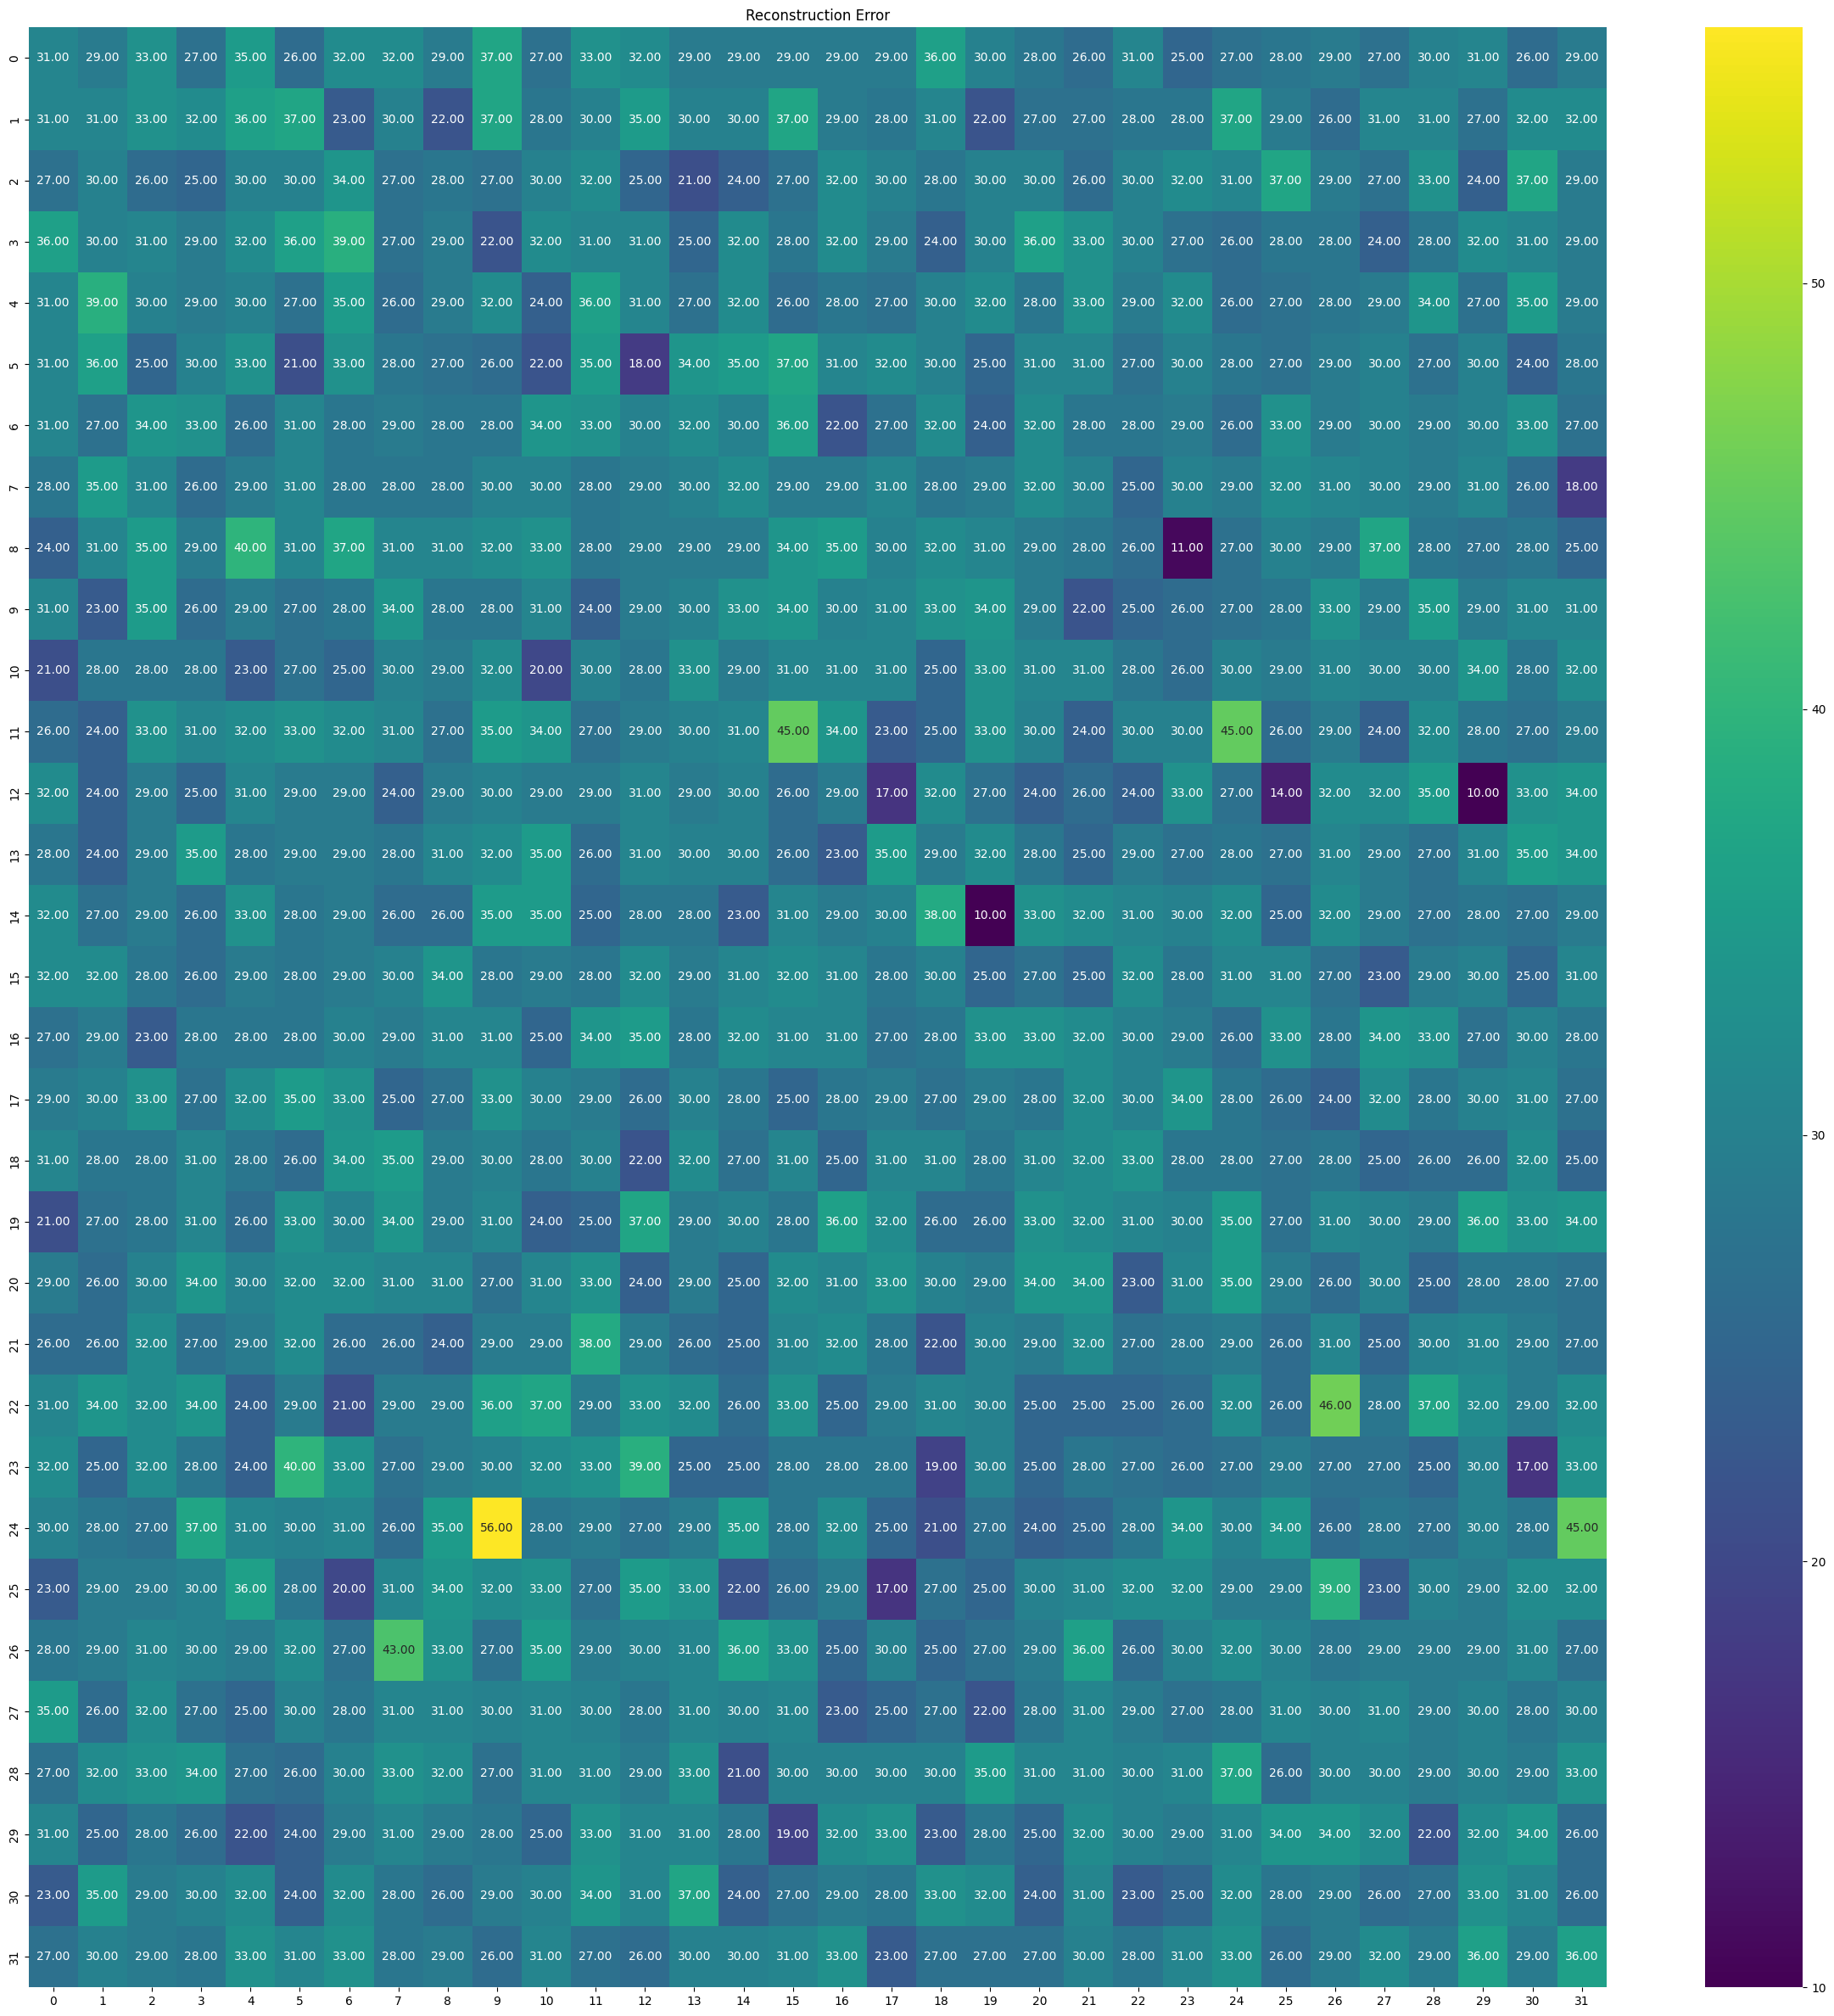

In [19]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(sparsities[:, :, 1], annot=True, fmt=".2f", cmap='viridis')
plt.show()

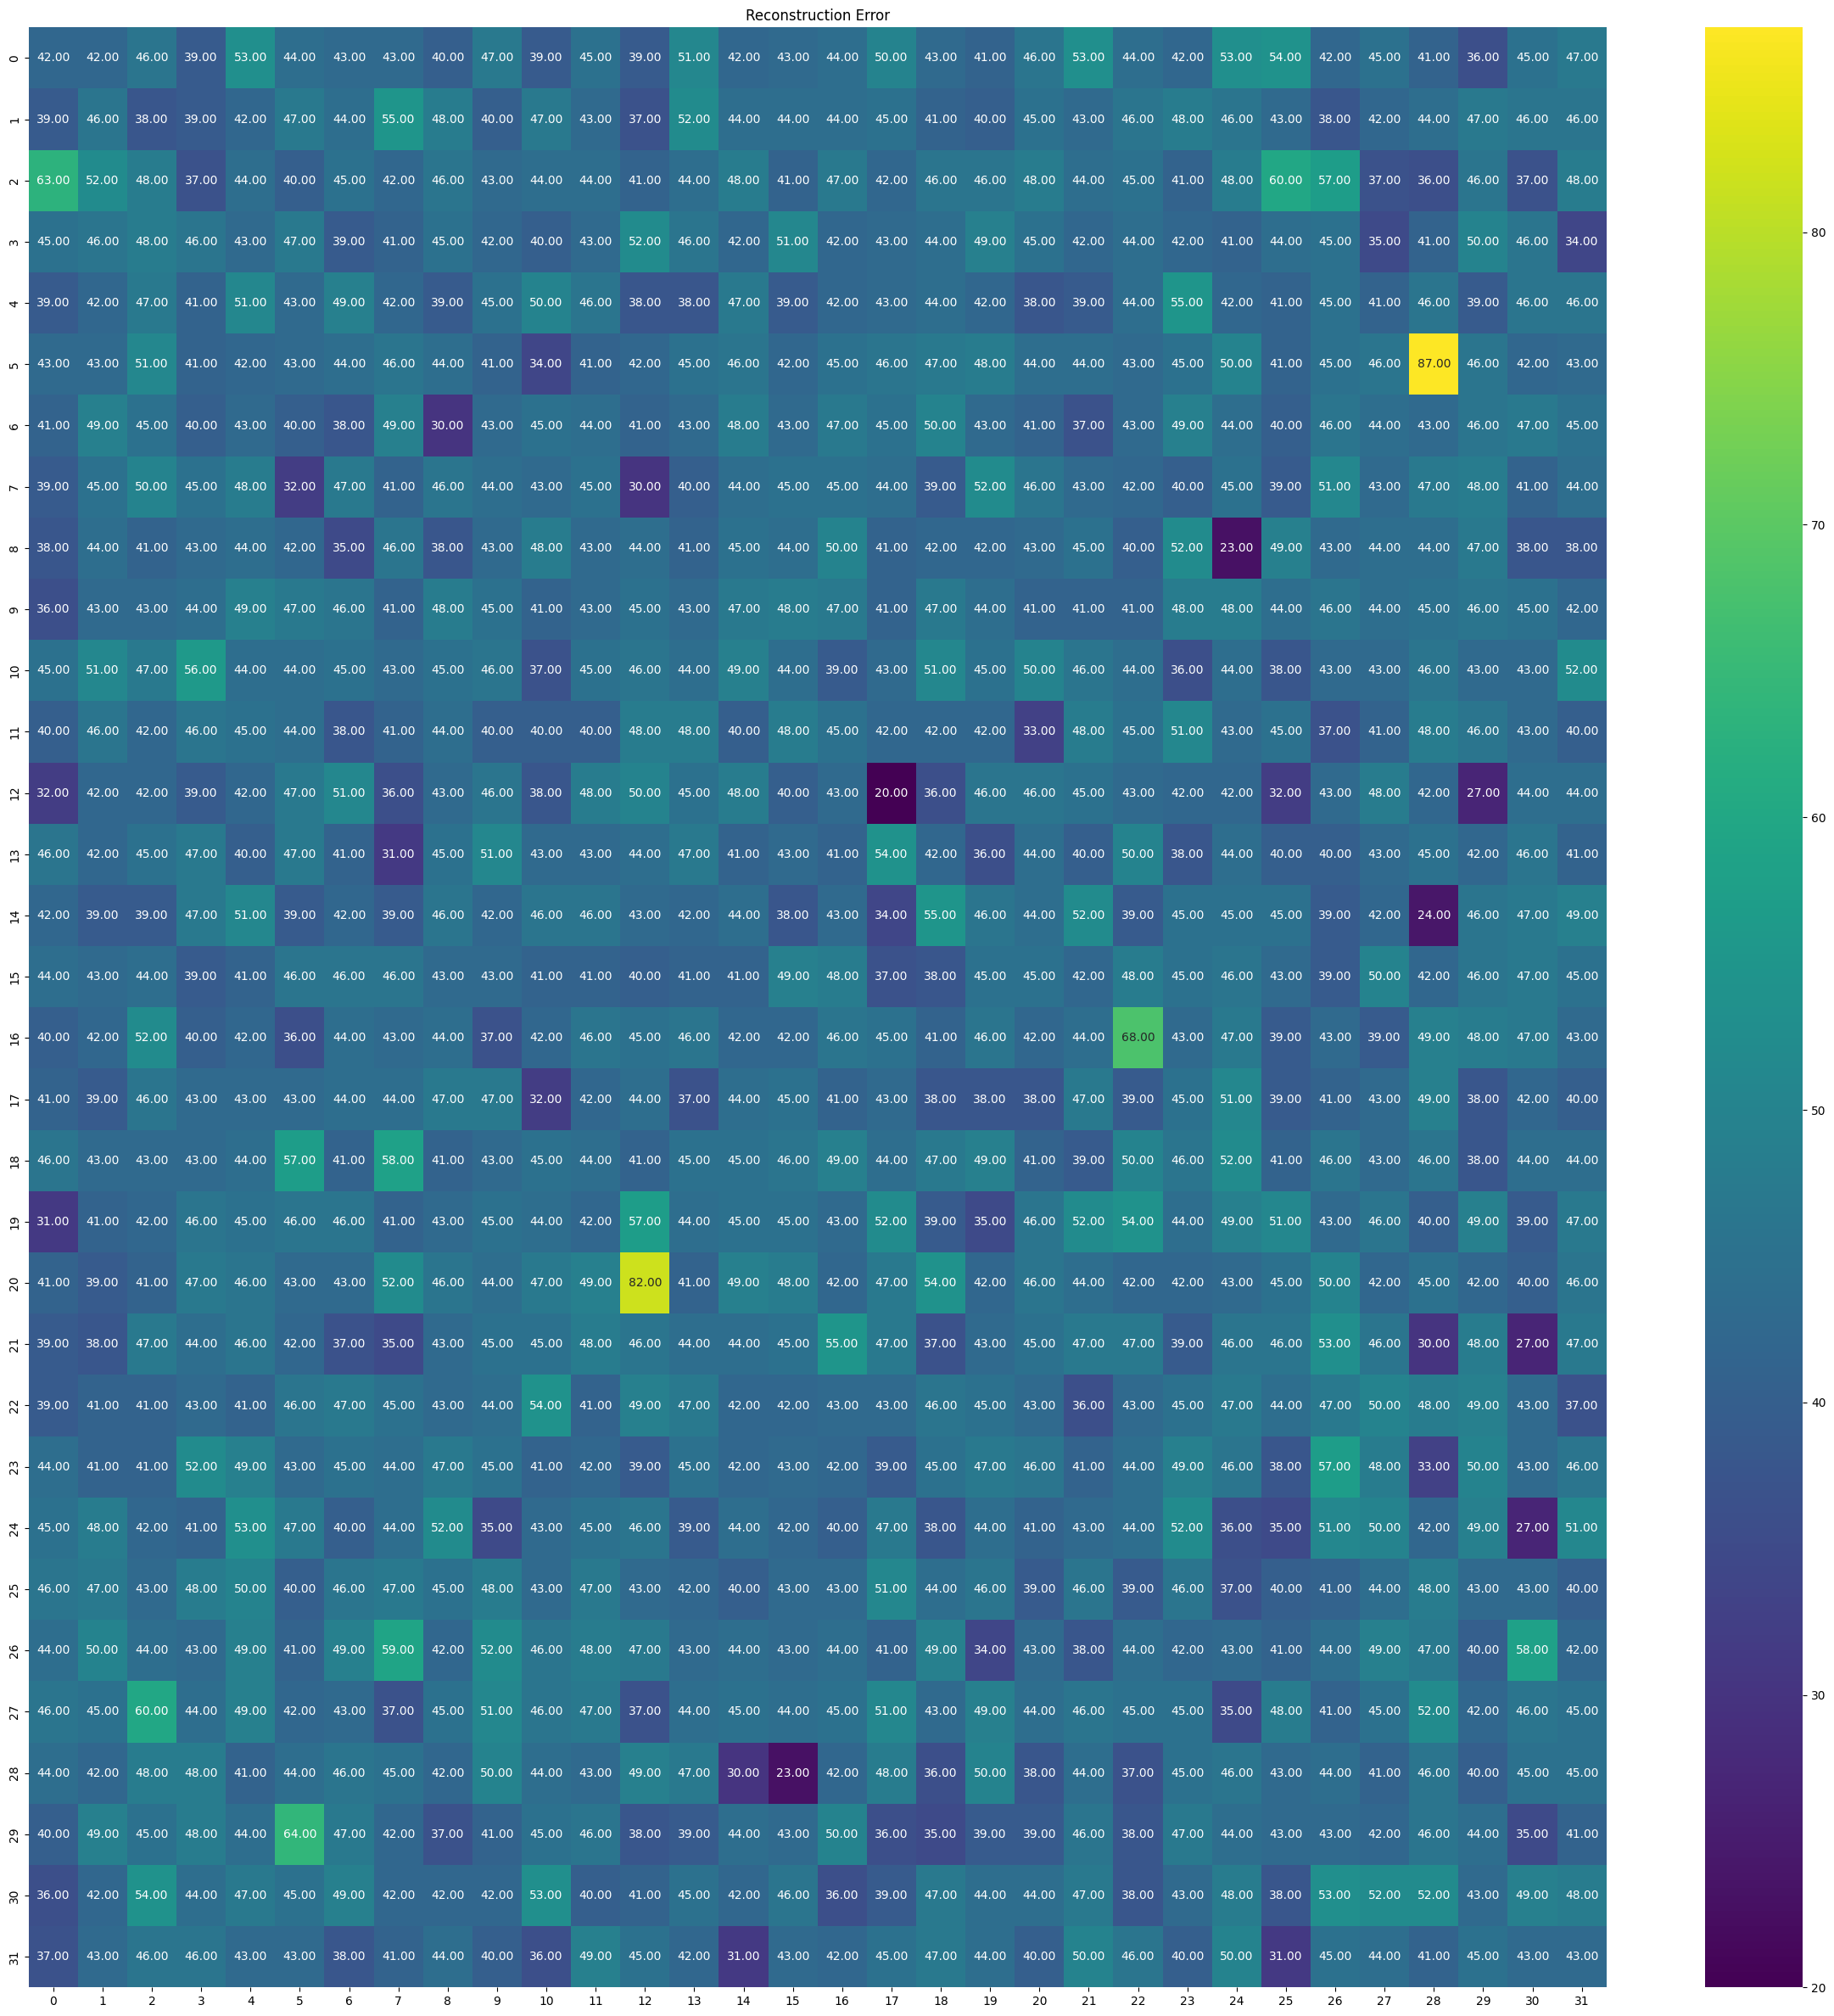

In [20]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(sparsities[:, :, 2], annot=True, fmt=".2f", cmap='viridis')
plt.show()

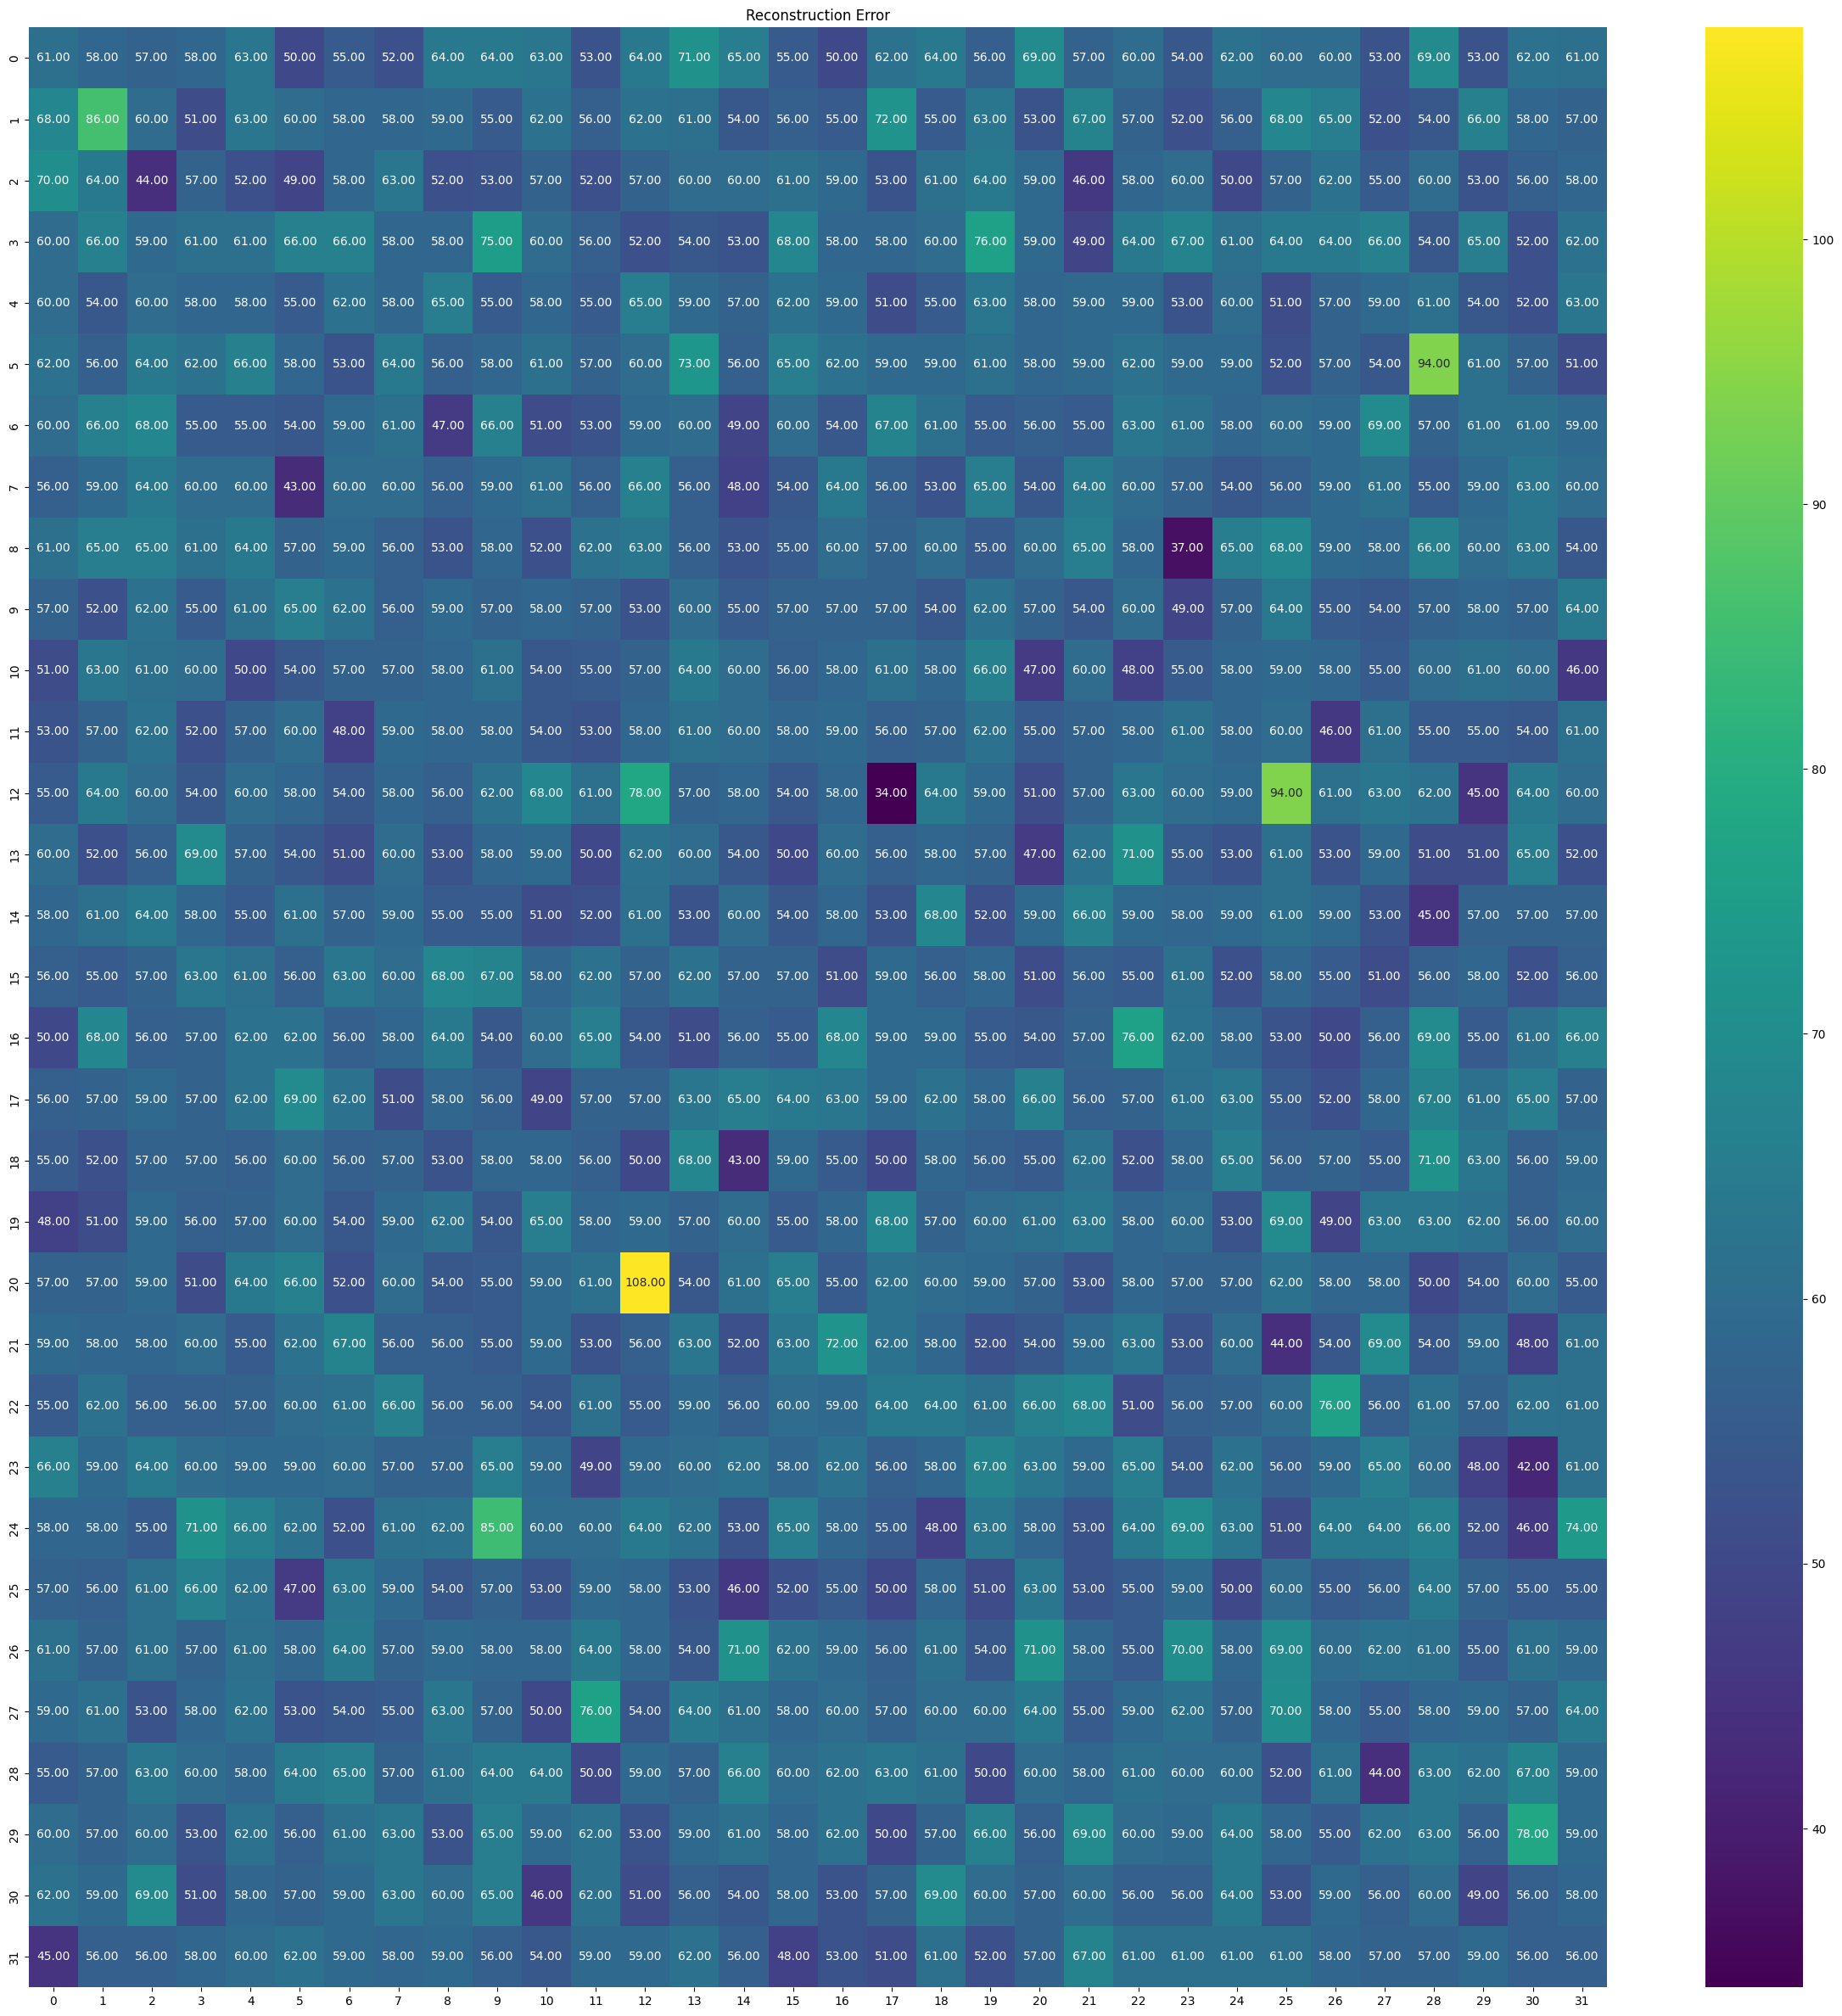

In [21]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(sparsities[:, :, 3], annot=True, fmt=".2f", cmap='viridis')
plt.show()

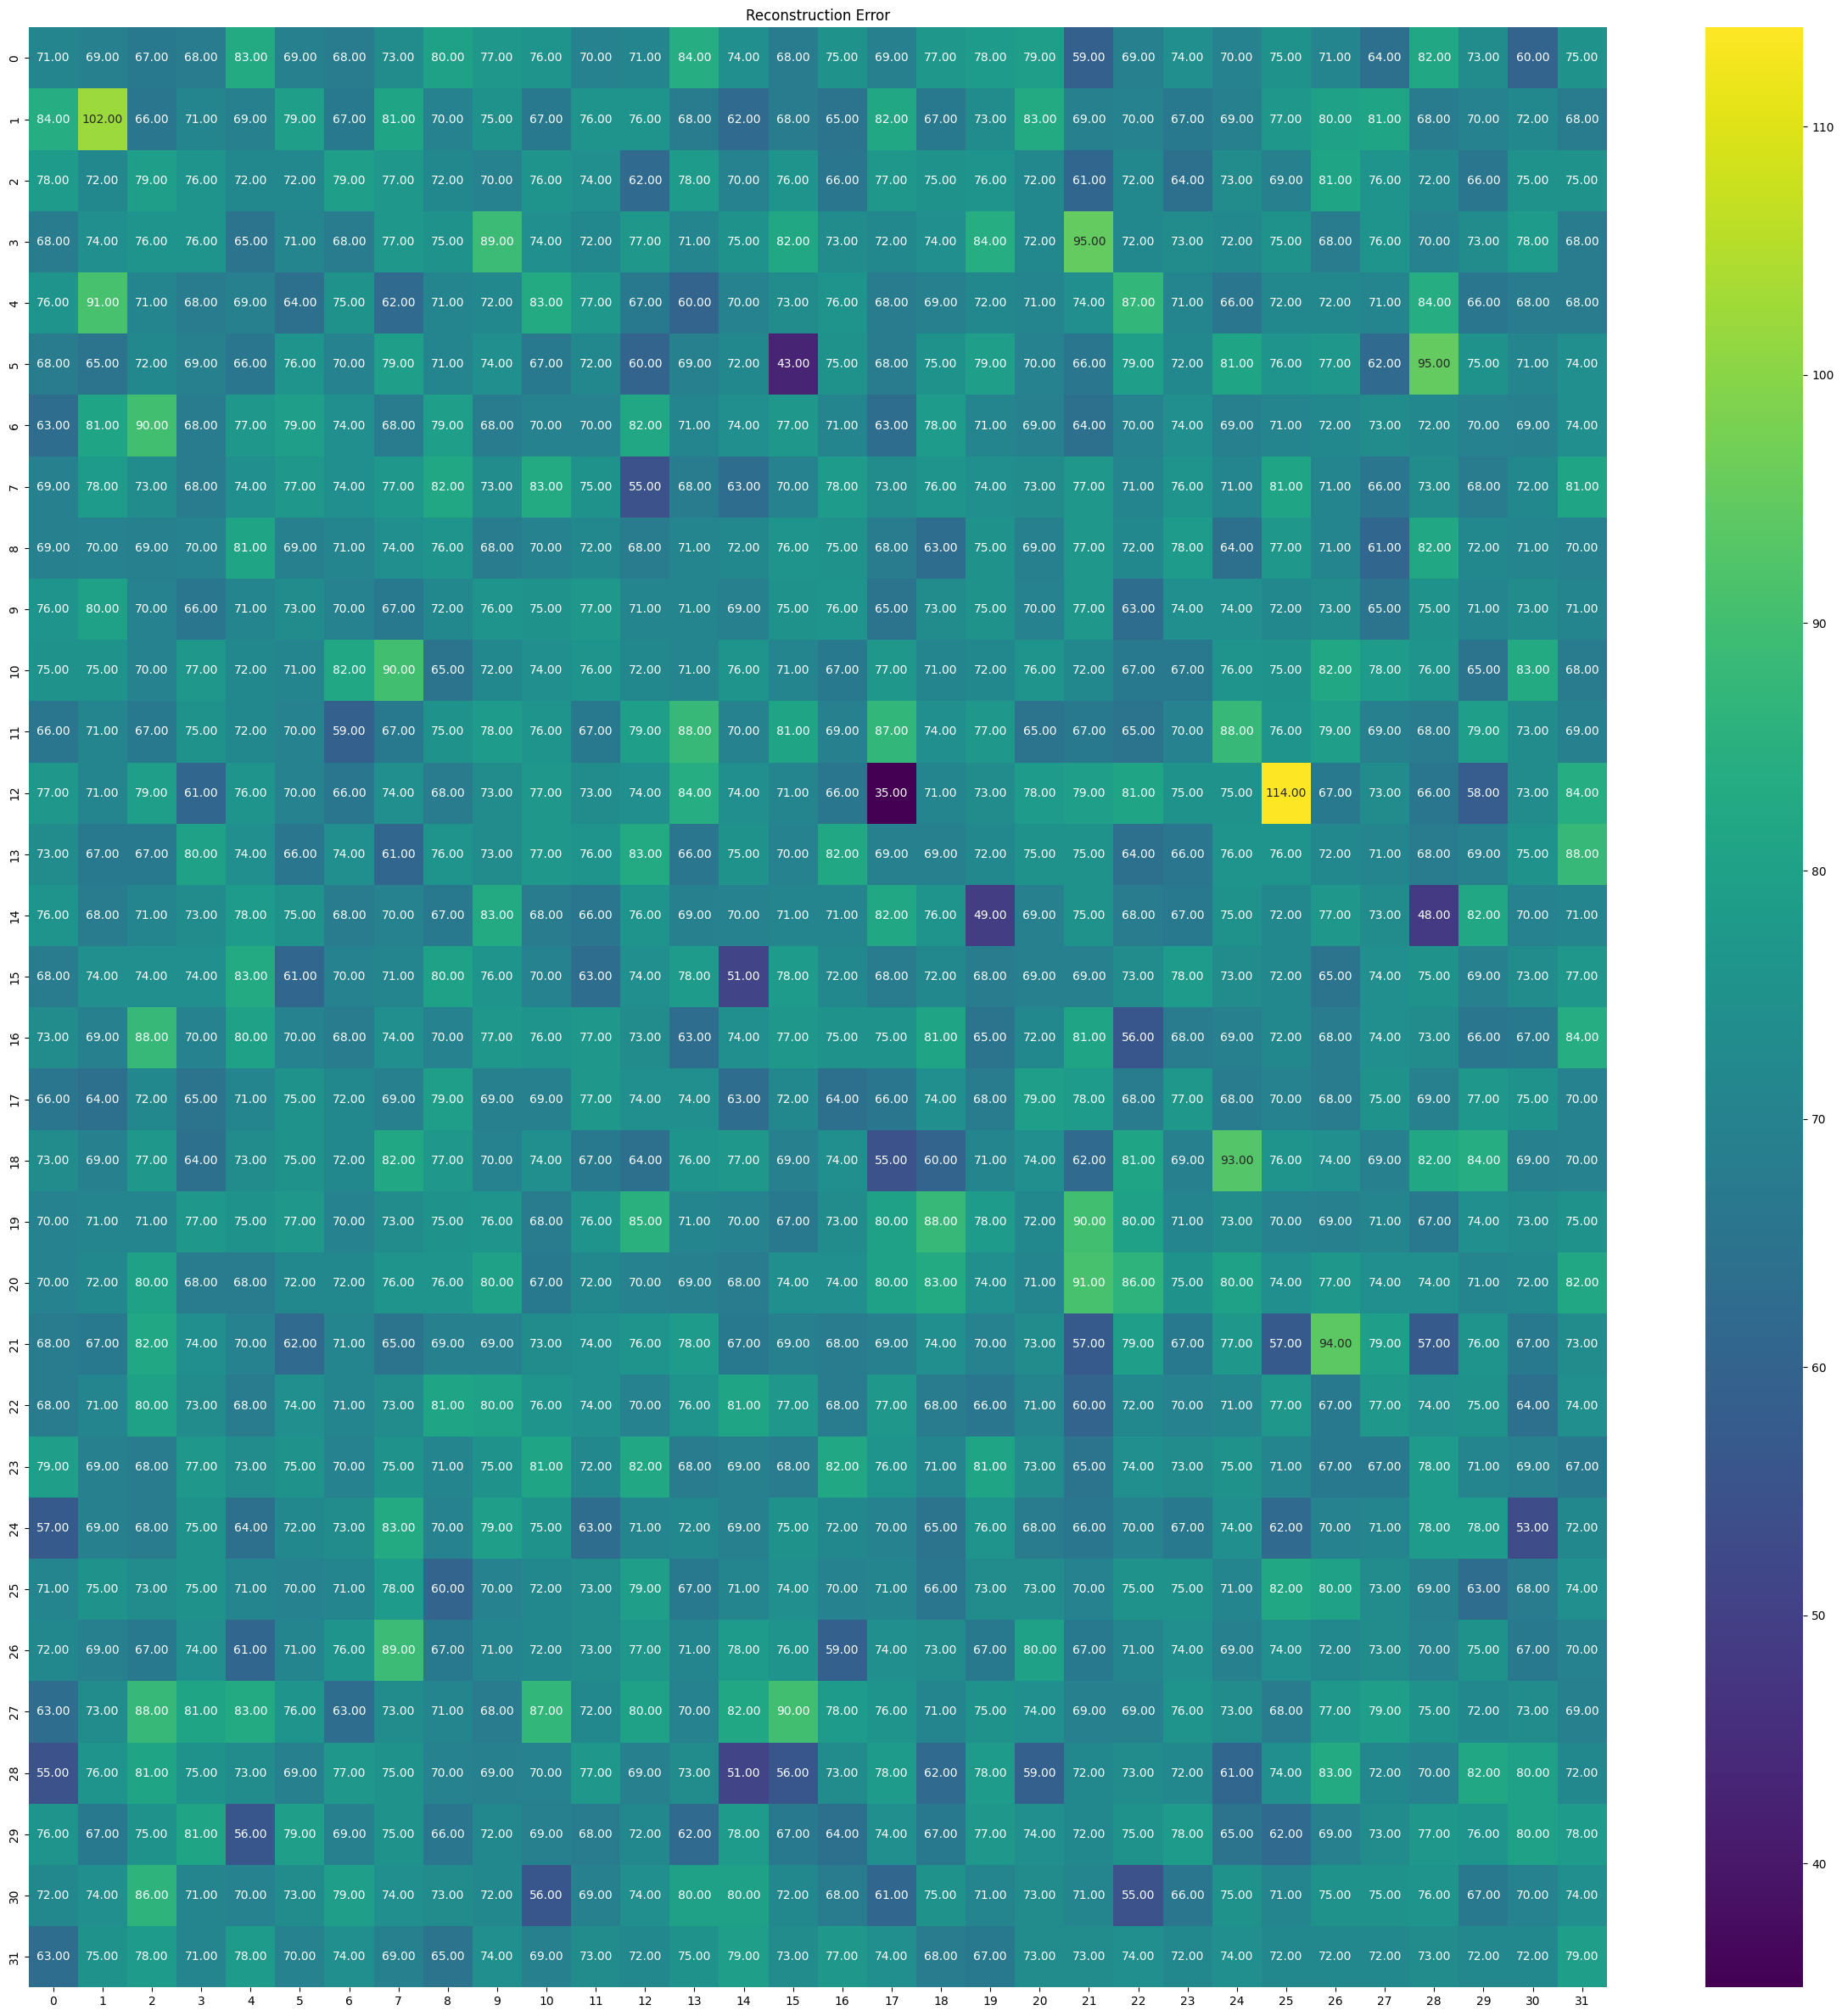

In [22]:
plt.figure(figsize=(30, 30))
plt.xlabel('Image Row')
plt.ylabel('Sample Percentage')
plt.title('Reconstruction Error')
sns.heatmap(sparsities[:, :, 4], annot=True, fmt=".2f", cmap='viridis')
plt.show()